## **Load the dependancies**

In [1]:
#!pip install jovian opendatasets --quiet

In [2]:
import jovian
import os
import opendatasets as od

<IPython.core.display.Javascript object>

In [3]:
od.download('https://www.kaggle.com/c/pubg-finish-placement-prediction/data')

Skipping, found downloaded files in "./pubg-finish-placement-prediction" (use force=True to force download)


In [4]:
os.listdir()

['submission.csv',
 'pubg-finish-placement-prediction',
 '__notebook_source__.ipynb']

In [5]:
os.listdir('pubg-finish-placement-prediction')

['test_V2.csv',
 'cleaned_data.csv',
 'train_V2.csv',
 'sample_submission_V2.csv',
 'Highly_correlated_data.csv']

In [6]:
# Importing the required libraries for this project
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import plotly as px
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [7]:
# Loading the data
train = pd.read_csv('pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('pubg-finish-placement-prediction/test_V2.csv')
print(train.shape, test.shape)

(4446966, 29) (1934174, 28)


In [8]:
test.tail()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
1934169,a316c3a13887d5,80e82180c90951,f276da5fd73536,1,2,381.00,3,0,7,4,...,-1,1,0.0,0,0.000,0,0,1799.00,5,1526
1934170,5312146b27d875,147264a127c56e,fb77cbfe094a6b,0,0,0.00,0,0,0,64,...,-1,0,0.0,0,0.000,0,0,1195.00,3,1496
1934171,fc8818b5b32ad3,7bbb4779ebedd5,efb74d5f6e9779,0,0,91.96,0,0,3,24,...,1482,0,0.0,0,7.798,1,0,3327.00,3,0
1934172,a0f91e35f8458f,149a506a64c2b1,3a2cf335bc302f,1,2,138.60,0,0,12,25,...,1456,1,0.0,0,0.000,0,0,1893.00,4,0
1934173,3696fc9f3a42b2,c770d7feaf020f,9d4e2b6d506fd0,0,0,19.80,0,0,0,86,...,-1,0,0.0,0,0.000,0,0,68.89,0,1551


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [10]:
train.memory_usage()

Index                   128
Id                 35575728
groupId            35575728
matchId            35575728
assists            35575728
boosts             35575728
damageDealt        35575728
DBNOs              35575728
headshotKills      35575728
heals              35575728
killPlace          35575728
killPoints         35575728
kills              35575728
killStreaks        35575728
longestKill        35575728
matchDuration      35575728
matchType          35575728
maxPlace           35575728
numGroups          35575728
rankPoints         35575728
revives            35575728
rideDistance       35575728
roadKills          35575728
swimDistance       35575728
teamKills          35575728
vehicleDestroys    35575728
walkDistance       35575728
weaponsAcquired    35575728
winPoints          35575728
winPlacePerc       35575728
dtype: int64

In [11]:
train.memory_usage().sum()

1031696240

The size of the PUBG dataset is pretty big
so here's a script to make the dataset smaller without losing information.

-Iterate over every column<br>
- Determine if the column is numeric<br>
- Determine if the column can be represented by an integer<br>
- Find the min and the max value<br>
- Determine and apply the smallest datatype that can fit the range of values

In [12]:
def reduce_memory(df):
  """ Iterate through all the columns of dataframe and modify data type to reduce the memory usage """

  initial_mem = df.memory_usage().sum()/1024**2

  for col in df.columns:
    col_type = df[col].dtype

    if col_type != 'object':
      c_min = df[col].min()
      c_max = df[col].max()

      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max :
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
      
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)

  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
      initial_mem, end_mem, 100 * (initial_mem - end_mem) / initial_mem))

In [13]:
reduce_memory(train)
reduce_memory(test)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)


## **Exploratory Data Analysis (EDA)**

In [14]:
# Unique count of Id, groupId, matchId

for i in ['Id','groupId','matchId']:
    print(f'unique [{i}] count:', train[i].nunique())

unique [Id] count: 4446966
unique [groupId] count: 2026745
unique [matchId] count: 47965


### **Exploring Different Match Type :**
- Solo - One can play alone (solo,solo-fpp,normal-solo,normal-solo-fpp)
- Duo - Play with a friend (duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp)
- Squad - Play with 4 friends (squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp)

<AxesSubplot:>

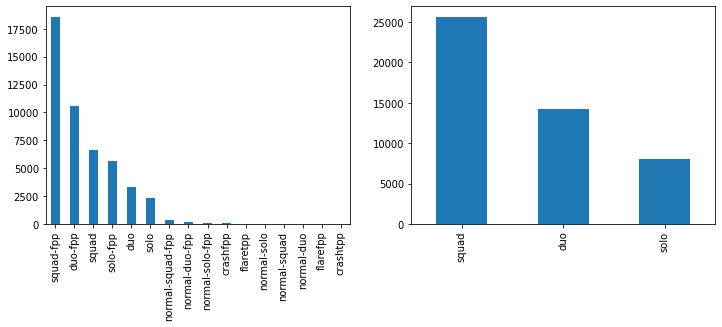

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Left subplot
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

#Right subplot
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

In [16]:
train.matchType.value_counts()

squad    2403625
duo      1322628
solo      720713
Name: matchType, dtype: int64

### **Player Analysis :**
- Players in a match and group
- During a game, 100 players join the same server, so in the case of duos the max teams are 50 and in the case of squads the max teams are 25.

In [17]:
match = train.groupby(['matchType','matchId']).size().to_frame('players in match') 
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group') 

In [18]:
match

players in match
matchType matchId                         
duo       0003b92987589e               100
          0006eb8c17708d                93
          00086c74bb4efc                98
          001125344b660c                96
          001360264d4b5f                91
...                                    ...
squad     fff4d3cbb6c317               100
          fffa170cf8ed83                93
          fffd74b5150cb4                97
          fffe562611d981                94
          fffe92232706aa                93

[47965 rows x 1 columns]

In [19]:
group

players in group
matchType matchId        groupId                         
duo       0003b92987589e 024136db14272c                 2
                         058b63035c6c08                 2
                         0c7fbc2742917b                 2
                         1add3b8ce32302                 2
                         1ed2da8e6c07b5                 2
...                                                   ...
squad     fffe92232706aa b671eab579d429                 1
                         bd5b4ecf8067ab                 3
                         c8e95cc6c06d41                 6
                         d57f3a3ed40913                 4
                         d8fa9cfd6f9560                 7

[2026745 rows x 1 columns]

### **Check correlation of the feature with Winning Percentage**

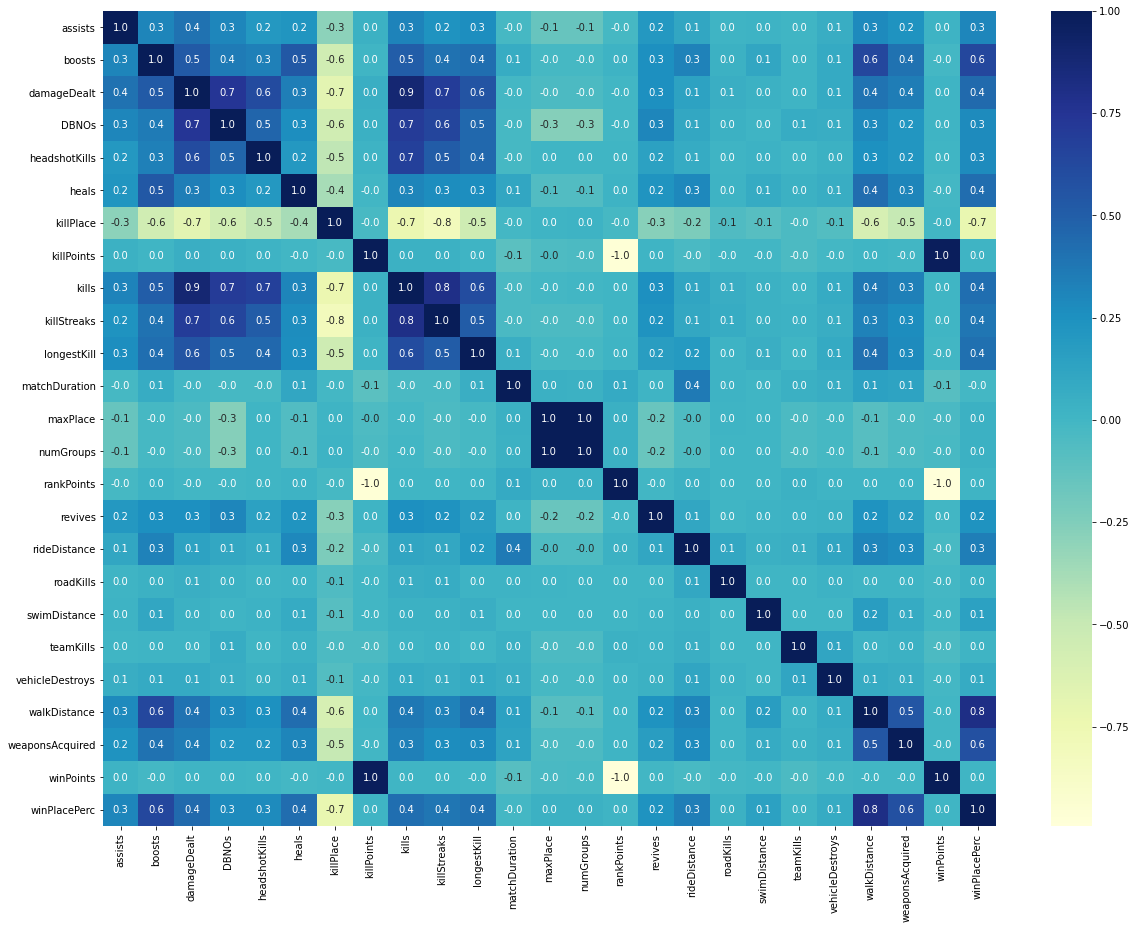

In [20]:
plt.figure(figsize=(20, 15))
sns.heatmap(train.corr(), annot=True, fmt= '.1f', cmap="YlGnBu")
plt.show()

**Feature Engineering**

### **Analysing the Kills**

In [21]:
print("On an average a person kills {:.4f} players, while the maximum kills ever recorded is {}."
     .format(train['kills'].mean(), train['kills'].max()))

On an average a person kills 0.9248 players, while the maximum kills ever recorded is 72.


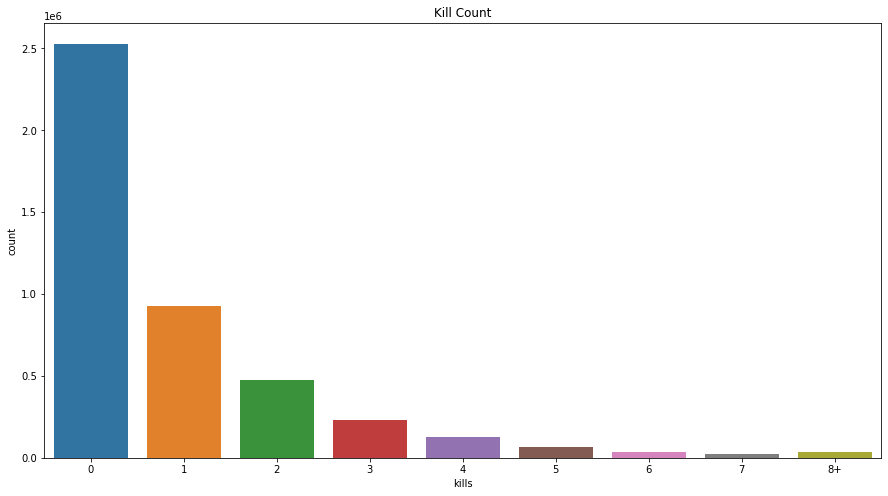

In [22]:
data = train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,8))
sns.countplot(x = data['kills'].astype('str').sort_values())
plt.title("Kill Count")
plt.show()

- **It seems most of the people cannot even make a single kill. But atleast they deal with some damage**

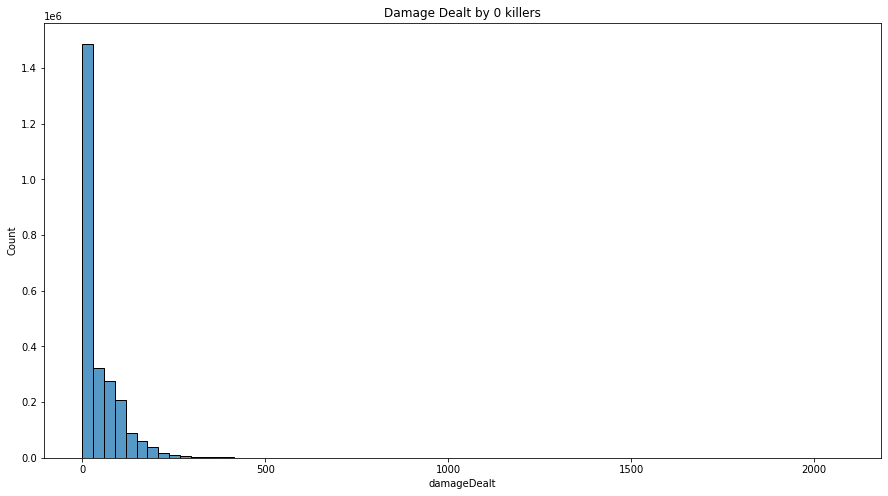

In [23]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,8))
plt.title("Damage Dealt by 0 killers")
sns.histplot(data['damageDealt'], bins=70)
plt.show()

In [24]:
print("A total of {} players have won without a single kill!".format(len(data[data['winPlacePerc']==1])))
data1 = train[train['damageDealt'] == 0].copy()
print("A total of {} players have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1])))

A total of 16666 players have won without a single kill!
A total of 4770 players have won without dealing damage!


- **Effect of Kiiling on Winning percentage**

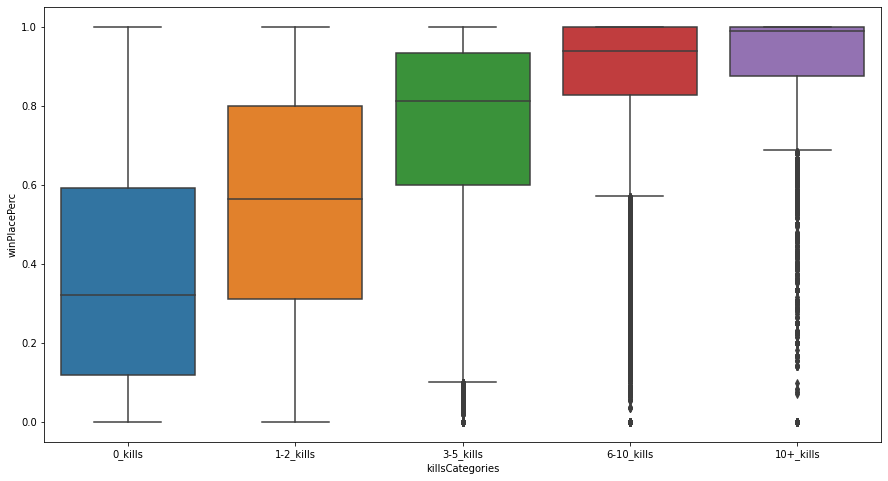

In [25]:
kills = train.copy()
kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60],
                                  labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])
plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

- **As shown above by the increasing mean of win percentage placement, we found that kill count was correlated with our target variable, which makes sense because more kills usually means a player is better skilled and will rank closer to the top.**

- **Kills has a high correlation with winPlacePerc.**

### **Analysing Running**

In [26]:
print("{} players walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).".format(len(data[data['walkDistance'] == 0])))

98054 players walked 0 meters. This means that either they die before even taking a step or they have just joined the game but are away from keyboard (more possible).


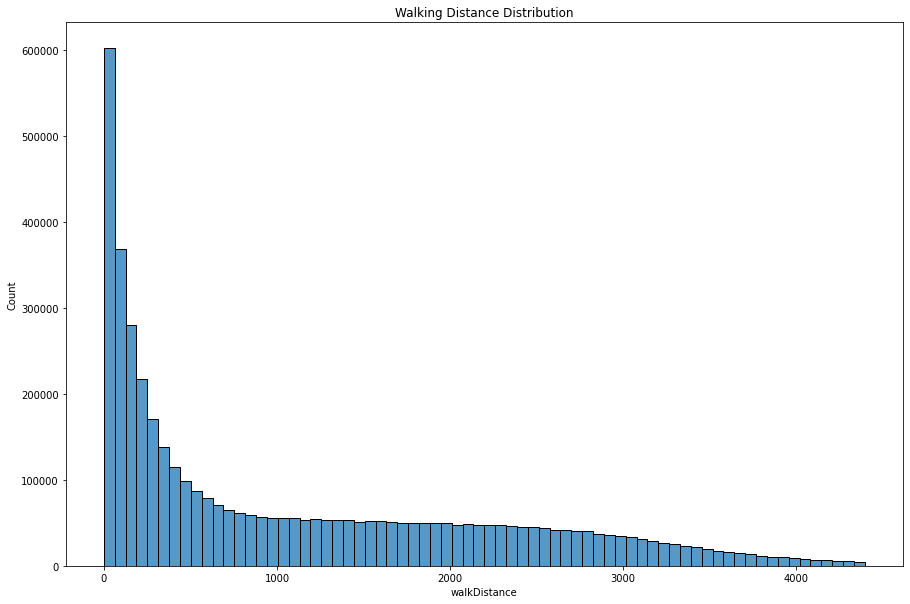

In [27]:
data = train.copy()
data = data[data['walkDistance'] < train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution")
sns.histplot(data['walkDistance'], bins = 70)
plt.show()

- **Analysing Running: Effect of Running on Winning Percentage**

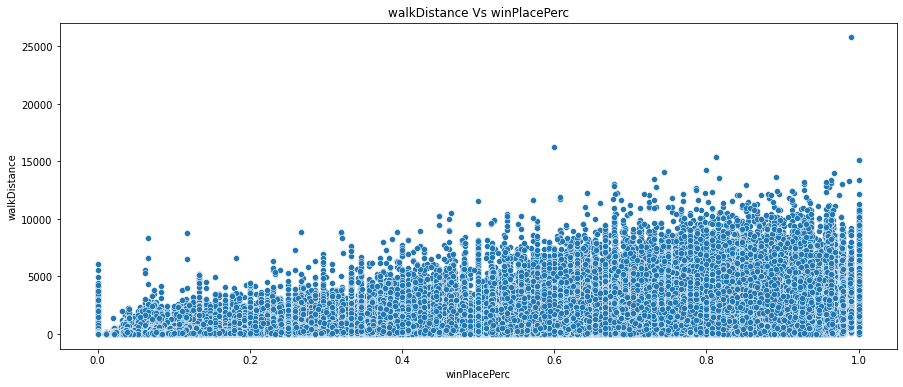

In [28]:
plt.figure(figsize=(15,6))
plt.title('walkDistance Vs winPlacePerc')
sns.scatterplot(x="winPlacePerc", y="walkDistance",  data=train)
plt.show()

- **Walking has a high correlation with winPlacePerc.**

### **Analysing Riding**

In [29]:
print("An average person drives for {:.1f}m, 99% of people have drived {}m or less, while THE RIDER rode for {}m.".format(train['rideDistance'].mean(), train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

An average person drives for 606.1m, 99% of people have drived 6966.0m or less, while THE RIDER rode for 40710.0m.


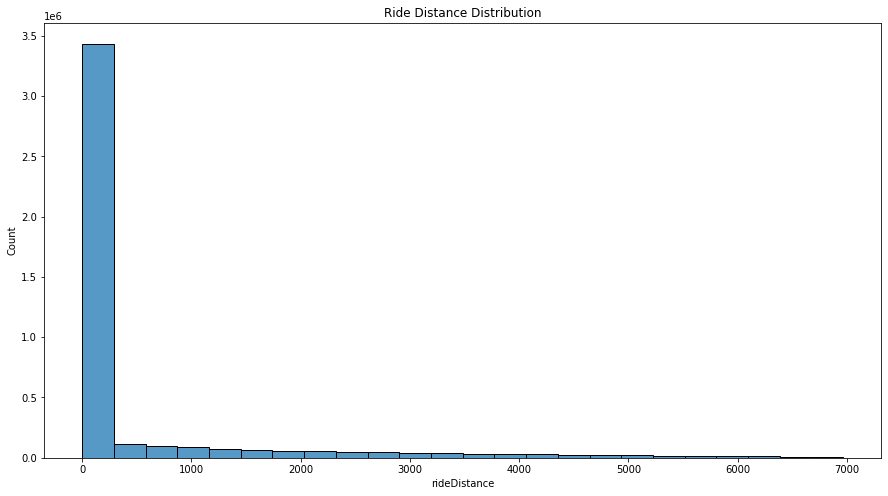

In [30]:
data = train.copy()
data = data[data['rideDistance'] < train['rideDistance'].quantile(0.99)]
plt.figure(figsize=(15,8))
plt.title("Ride Distance Distribution")
sns.histplot(data['rideDistance'])
plt.show()

In [31]:
print("{} players drived for 0 meters. This means that they like trekking more than riding.".format(len(data[data['rideDistance'] == 0])))

3309429 players drived for 0 meters. This means that they like trekking more than riding.


- **Analysing Riding: Effect of Riding on Winning Percentage**

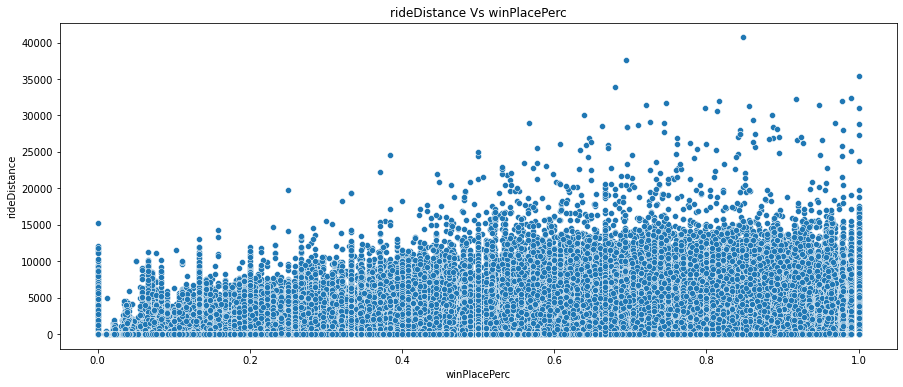

In [32]:
plt.figure(figsize=(15,6))
plt.title('rideDistance Vs winPlacePerc')
sns.scatterplot(x="winPlacePerc", y="rideDistance", data=train)
plt.show()

- **The scatter plot above indicates there is a small correlation between driving and winning.**

### **Theoretically, if a player is able to destroy the vehicle it indicates the he/she is skilled. Let's check if this theory is correct.**

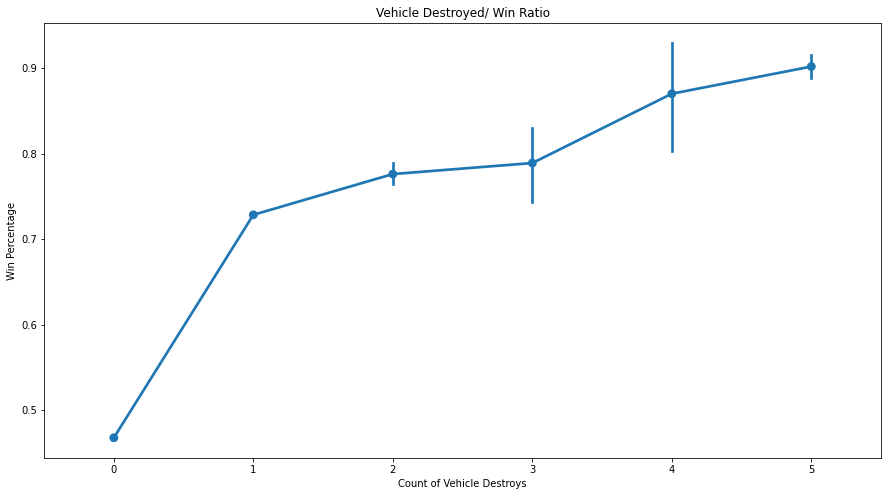

In [33]:
plt.figure(figsize =(15,8))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data, alpha=0.5)
plt.xlabel('Count of Vehicle Destroys')
plt.ylabel('Win Percentage')
plt.title('Vehicle Destroyed/ Win Ratio')
plt.show()

- **Destroying vehicles increases your chances of winning!**

### **Analysing Healing and Boosting**

In [34]:
print("On an average a person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))
print("On an average a person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

On an average a person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
On an average a person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


- **Analysing Healing and Boosting: Effect of Healing & Boosting on Winning Percentage**

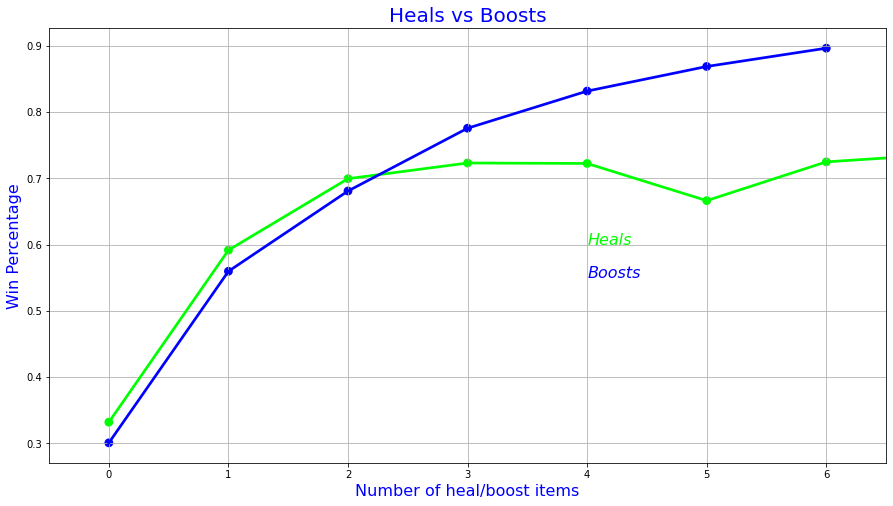

In [35]:
data = train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(15,8))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 16,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 16,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 16,color='blue')
plt.ylabel('Win Percentage',fontsize = 16,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

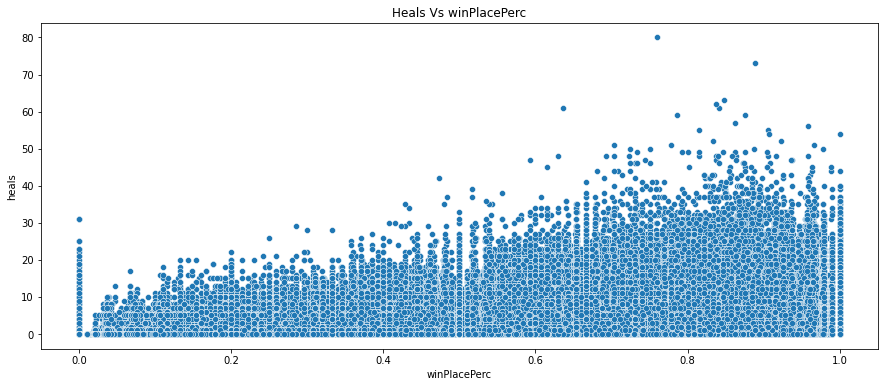

In [36]:
plt.figure(figsize=(15,6))
plt.title('Heals Vs winPlacePerc')
sns.scatterplot(x="winPlacePerc", y="heals", data=train)
plt.show()

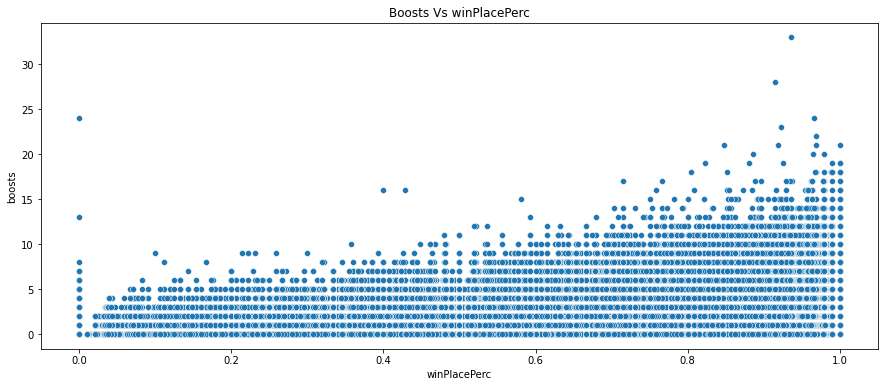

In [37]:
plt.figure(figsize=(15,6))
plt.title('Boosts Vs winPlacePerc')
sns.scatterplot(x="winPlacePerc", y="boosts", data=train)
plt.show()

- **Both healing and boosts have a high correlation with winning, however boosts matter more. Both the plots shows abnormal behaviour at 0**

### **Effect of Killing in different Game type: Solo, Duos and Squad on Winning Percentage**

In [38]:
solos = train[train['numGroups']>50] #Solo game played by more than 50 different groups
duos = train[(train['numGroups']>25) & (train['numGroups']<=50)] #Duo game can consist of a maximum of 50 groups(50x2=100) 
squads = train[train['numGroups']<=25] # Squad game can consist a maximum of 25 groups(25x4=100)
print("{} ({:.2f}%) of games are solo, {} ({:.2f}%) are duo and {} ({:.2f}%) are squad games.".format(len(solos), 100*len(solos)/len(train), len(duos), 100*len(duos)/len(train), len(squads), 100*len(squads)/len(train),))

709111 (15.95%) of games are solo, 3295326 (74.10%) are duo and 442529 (9.95%) are squad games.


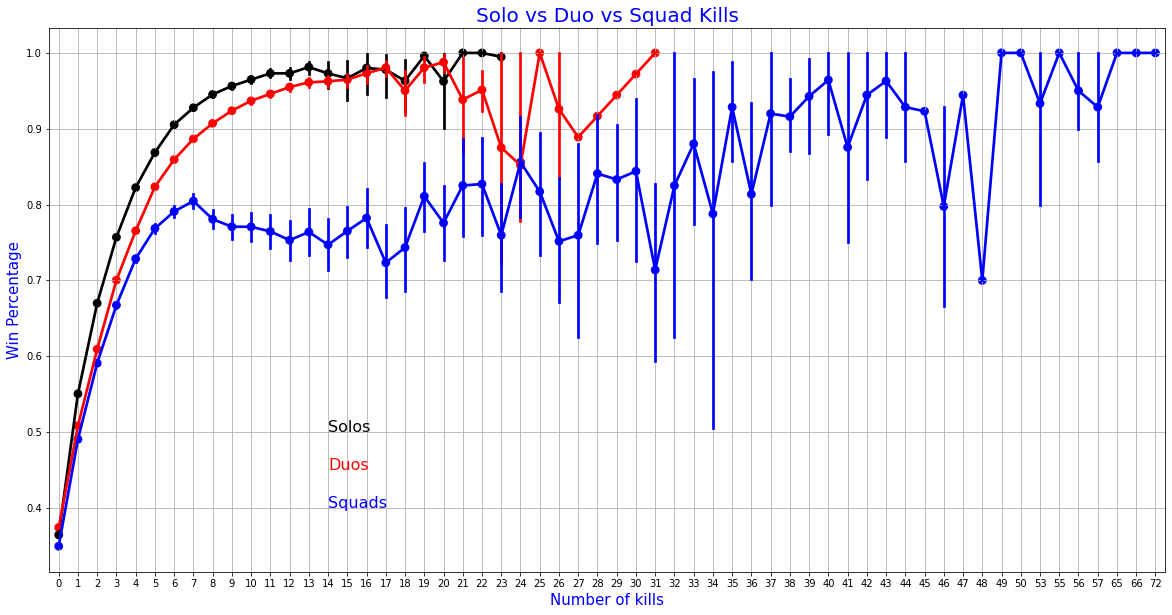

In [39]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='black',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='red',alpha=0.6)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='blue',alpha=0.6)
plt.text(14,0.5,'Solos',color='black',fontsize = 16)
plt.text(14,0.45,'Duos',color='red',fontsize = 16)
plt.text(14,0.4,'Squads',color='blue',fontsize = 16)
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

- **Solos and duos behave the same, but when playing squads kills don't matter that much.**

### **Effect of Knocking (DBNO), Assisting or Reviving on Winning Percentage**

- **In SOLO mode**

In [40]:
solo_data = train.copy()
solo_data = solo_data[solo_data['matchType'] == 'solo']
solo_data['assists'] = 0
solo_data['revives'] = 0
solo_data['DBNOs'] = 0

- **In DUO mode**

In [41]:
duo_data = train.copy()
duo_data = duo_data[duo_data['matchType'] == 'duo']
print("In DUO mode on an average a player knocks {} times and 99% of players knocks {} times and a noob knocked out {} times."
      .format(round(duo_data['DBNOs'].mean(),3), duo_data['DBNOs'].quantile(0.99), duo_data['DBNOs'].max())) 
print("In DUO mode on an average a player revives {} times and 99% of players revives {} times and a doctor revives {} times."
      .format(round(duo_data['revives'].mean(),3), duo_data['revives'].quantile(0.99), duo_data['revives'].max())) 
print("In DUO mode on an average a player has {} assists and 99% of players has {} assists and a master have {} assists."
      .format(round(duo_data['assists'].mean(),3), duo_data['assists'].quantile(0.99), duo_data['assists'].max())) 

In DUO mode on an average a player knocks 0.625 times and 99% of players knocks 4.0 times and a noob knocked out 33 times.
In DUO mode on an average a player revives 0.159 times and 99% of players revives 2.0 times and a doctor revives 39 times.
In DUO mode on an average a player has 0.217 assists and 99% of players has 2.0 assists and a master have 15 assists.


- **In SQUAD mode**

In [42]:
squad_data = train.copy()
squad_data = squad_data[squad_data['matchType'] == 'squad']
print("In SQUAD mode on an average a player knocks {} times and 99% of players knocks {} times and a noob knocks {} times."
      .format(round(squad_data['DBNOs'].mean(),3), squad_data['DBNOs'].quantile(0.99), squad_data['DBNOs'].max())) 
print("In SQUAD mode on an average a player revives {} times and 99% of players revives {} times and a doctor revives {} times."
      .format(round(squad_data['revives'].mean(),3), squad_data['revives'].quantile(0.99), squad_data['revives'].max())) 
print("In SQUAD mode on an average a player has {} assists and 99% of players has {} assists and a master has {} assists."
      .format(round(squad_data['assists'].mean(),3), squad_data['assists'].quantile(0.99), squad_data['assists'].max())) 

In SQUAD mode on an average a player knocks 0.873 times and 99% of players knocks 6.0 times and a noob knocks 53 times.
In SQUAD mode on an average a player revives 0.217 times and 99% of players revives 2.0 times and a doctor revives 23 times.
In SQUAD mode on an average a player has 0.295 assists and 99% of players has 3.0 assists and a master has 17 assists.


## **Data Cleaning: Outlier Detection and Removal - Finding the fraudsters**

In [43]:
# Check row with NaN value
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [44]:
train.drop(train[train['winPlacePerc'].isnull()].index, inplace=True)

In [45]:
train.shape

(4446965, 29)

### **Outliers in Killing: Aim Hacks**

- **totalDistance travelled by a player which is the sum total of rideDistance, walkDistance adn swimDistance**

In [46]:
# Engineer a new feature _totalDistance
train['_totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

# Engineer _headshot_rate feature --- headshots made per kill
train['_headshot_rate'] = train['headshotKills'] / train['kills']
train['_headshot_rate'] = train['_headshot_rate'].fillna(0)

In [47]:
#Defining functions for plotting graphs, we will be needing a lot of countplot and histplot
def show_countplot(column):
    plt.figure(figsize=(15,8))
    sns.countplot(data=train, x=column).set_title(column)
    plt.show()
    
def show_distplot(column):
    plt.figure(figsize=(15, 8))
    sns.histplot(train[column], bins=50)
    plt.show()

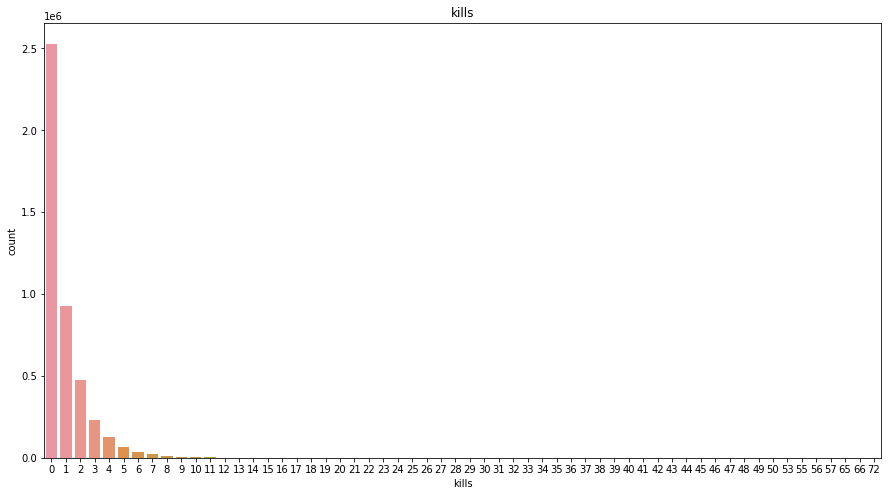

In [48]:
show_countplot('kills')

In [49]:
# Is it even possible to kill more than 40 people by acquiring more than 55 weapons and maintaining a total distance of less than 100m?
train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
156599,746aa7eabf7c86,5723e7d8250da3,f900de1ec39fa5,21,0,5479.0,0,12,7,4,...,0,0.0,0,0,23.709999,61,0,0.7000,23.709999,0.250000
672993,da31f191ace8ed,ce9a3c4950a8f2,17dea22cefe62a,10,0,5793.0,0,5,2,1,...,0,0.0,0,0,24.270000,56,0,1.0000,24.270000,0.087719
770454,2ade4369bccd12,9f9e64a3db8384,e024bf51bf1799,12,0,5557.0,0,7,4,1,...,0,0.0,0,0,85.550003,66,0,1.0000,85.550003,0.127273
1378200,f241fdbb4f94c6,fadbbc4cbb3e06,e024bf51bf1799,9,0,3707.0,0,5,1,5,...,0,0.0,0,0,46.709999,72,0,0.7778,46.709999,0.121951


In [50]:
# Is it even possible to kill more than 40 people without using any heals?
train[(train['kills'] >= 40) & (train['heals'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
160254,15622257cb44e2,1a513eeecfe724,db413c7c48292c,1,0,4033.0,0,40,0,1,...,0,0.0,1,0,718.299988,16,1500,1.0,718.299988,0.952381
2105633,770c02791306c4,48ca6706a90e10,6ee2c835176181,8,0,4272.0,40,34,0,1,...,0,0.0,0,0,80.400002,21,0,1.0,80.400002,0.790698
2316123,dbc81aa64a7e3d,c50fe5c54e8bb6,5d58307bae9b50,8,0,4106.0,31,3,0,1,...,0,0.0,0,0,1282.000000,22,0,1.0,1282.000000,0.075000
2601666,436d1530e9eb00,5c974c2bb9d9f0,fe7043ee6221c8,5,0,4347.0,0,31,0,1,...,0,0.0,0,0,134.300003,36,0,1.0,134.300003,0.584906
3924729,579949f753978c,108f4c00d80882,ff9cd80c0d8fb7,1,2,3680.0,0,35,0,1,...,0,0.0,0,0,1180.000000,2,1500,1.0,1180.000000,0.875000


In [51]:
# Drop these hackers
train.drop(train[(train['kills'] >= 40) & (train['weaponsAcquired'] > 55) & (train['_totalDistance'] < 100.0)].index, inplace=True)
train.drop(train[(train['kills'] >= 40) & (train['heals'] == 0)].index, inplace=True)

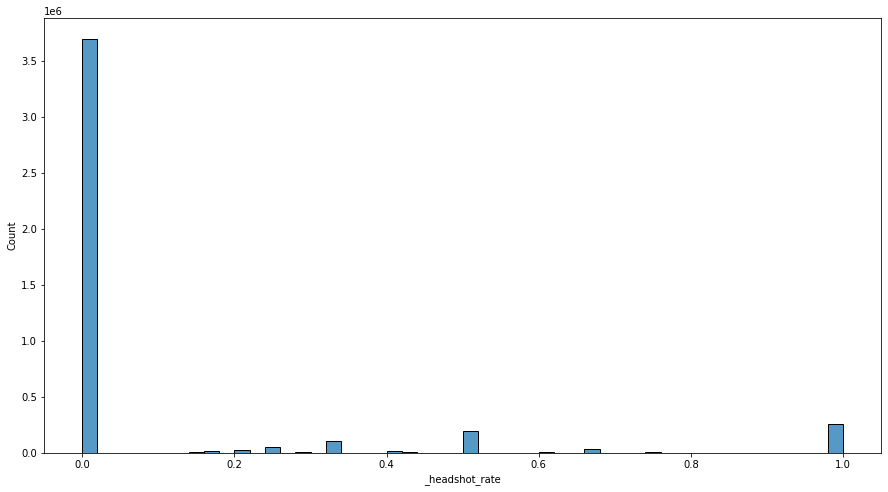

In [52]:
# Plot the distribution of headshot_rate
show_distplot('_headshot_rate')

In [53]:
# List of Hitman who made more than 10 kills and all the kills were done by headshot(perfect kill)
display(train[(train['_headshot_rate'] == 1) & (train['kills'] >=10)].shape)
train[(train['_headshot_rate'] == 1) & (train['kills'] >= 10)].head(10)

(24, 31)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate
281570,ab9d7168570927,add05ebde0214c,e016a873339c7b,2,3,1212.0,8,10,0,1,...,0,0.000000,0,0,2939.0,5,0,0.8462,2939.000000,1.0
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,0,0.000000,0,0,3422.0,8,1560,1.0000,8142.000000,1.0
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,0,0.000000,0,0,2105.0,5,1587,1.0000,2105.000000,1.0
908815,566d8218b705aa,a9b056478d71b2,3a41552d553583,2,5,1535.0,10,10,3,1,...,0,0.000000,2,0,2761.0,7,1519,0.9630,7948.000000,1.0
963463,1bd6fd288df4f0,90584ffa22fe15,ba2de992ec7bb8,2,6,1355.0,12,10,2,1,...,0,0.000000,0,0,2458.0,4,1562,1.0000,3476.000000,1.0
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,0,0.000000,0,0,2932.0,4,0,1.0000,8178.000000,1.0
1167959,c4f80d4be5c561,b4a7892189b5dd,c7f7733ebbd447,0,4,1065.0,6,10,1,1,...,0,0.000000,0,0,2450.0,7,1468,1.0000,2858.899902,1.0
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,0,0.000000,0,0,3915.0,5,0,1.0000,5963.000000,1.0
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,0,0.000000,0,0,3108.0,7,1500,1.0000,3108.000000,1.0
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,0,140.800003,0,0,2339.0,4,0,1.0000,2479.800049,1.0


- **It is unclear if these players are cheating or are the legends so, for now we are not deleting these players from the dataset.**

### **Killing without Moving**

In [54]:
# Create feature killsWithoutMoving
train['_killsWithoutMoving'] = ((train['kills'] > 0) & (train['_totalDistance'] == 0))

# Check players who kills without moving
display(train[train['_killsWithoutMoving'] == True].shape)
train[train['_killsWithoutMoving'] == True].head(10)

(1535, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.000000,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,0.0,0.000000,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.600006,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,0.0,0.000000,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.000000,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,0.0,0.200000,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.800003,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,0.0,0.000000,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.000000,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,0.0,1.000000,True
20881,40871bf43ddac7,2cea046b7d1dce,0600f86f11c6e4,0,0,506.100006,4,1,3,7,...,0.0,0,0,0.0,8,0,0.8000,0.0,0.166667,True
23298,b950836d0427da,1f735b1e00d549,ad860f4e162bbc,1,0,1124.000000,0,4,1,7,...,0.0,0,0,0.0,8,0,0.6000,0.0,0.333333,True
24640,aeced11d46de19,d4009ffa95bb4f,73f3ed869c9171,2,0,529.900024,0,2,11,12,...,0.0,0,0,0.0,8,0,0.8571,0.0,0.285714,True
25659,6626c4d47cffa0,ee3fe5c0d917c3,341341834b7941,0,1,128.899994,0,1,6,53,...,0.0,0,0,0.0,12,1500,0.2857,0.0,0.500000,True
30079,869331b90bfa3f,869ea3ad036e53,fa373e28ff5062,0,0,85.559998,0,0,0,46,...,0.0,0,0,0.0,4,0,0.8571,0.0,0.000000,True


In [55]:
# Drop kill without moving 'fraudsters'
train.drop(train[train['_killsWithoutMoving'] == True].index, inplace=True)

### **Longest Kill**

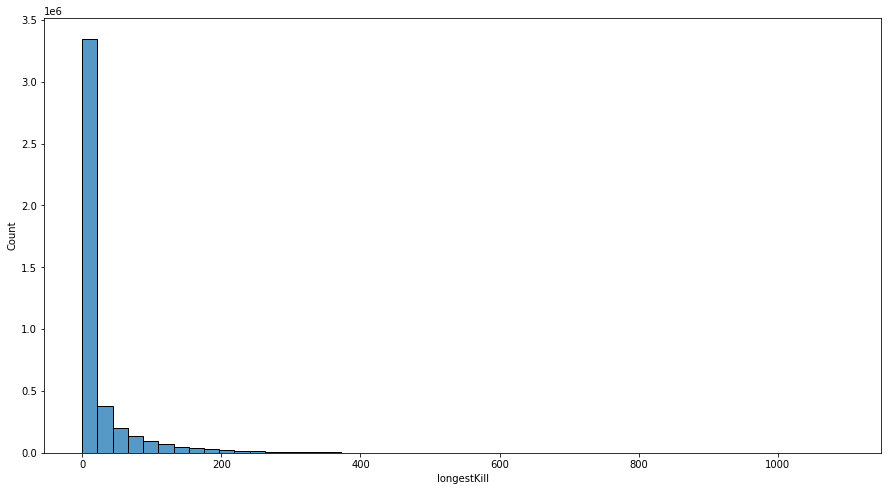

In [56]:
show_distplot('longestKill')

- **Is it even posssible to snipe (kill) someone from a distance > 1Km in this game?**
- **Let's take a look at the players who took these shots.**

In [57]:
train[train['longestKill'] >= 1000]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
202281,88e2af7d78af5a,34ddeede52c042,4346bc63bc67fa,0,3,783.900024,5,1,1,5,...,0.000000,0,1,3052.000000,9,0,0.9231,3775.199951,0.250000,False
240005,41c2f5c0699807,9faecf87ab4275,634edab75860b3,5,0,1284.000000,8,5,7,18,...,0.000000,0,0,48.869999,38,1500,0.5385,48.869999,0.454545,False
324313,ef390c152bcc3d,30fd444be3bbc1,4f7f8d6cf558b4,2,0,1028.000000,0,0,0,9,...,0.000000,0,0,1264.000000,26,0,1.0000,2981.000000,0.000000,False
656553,9948b058562163,c8cb8491112bf6,0104eeb664494d,6,0,1410.000000,17,5,0,3,...,0.000000,0,0,29.209999,30,1500,0.6000,29.209999,0.312500,False
803632,4e7e6c74e3c57d,94698690918933,da91b0c3d875f8,0,0,196.800003,0,0,0,51,...,0.000000,0,0,1074.000000,22,0,0.0000,3159.000000,0.000000,False
895411,1f5ba6e0cfb968,512ea24b831be3,5fb0d8b1fc16cf,4,0,1012.000000,11,5,0,5,...,0.000000,0,0,569.500000,18,0,0.9091,569.500000,0.500000,False
1172437,303a93cfa1f46c,8795d39fd0df86,9c8962b58bb3e3,2,1,329.299988,0,0,2,45,...,0.000000,0,0,832.500000,9,1500,0.2857,832.500000,0.000000,False
1209416,528659ff1c1aec,7d1ba83423551d,ea9386587d5888,0,6,1640.000000,0,7,0,1,...,0.000000,0,0,2848.000000,4,1500,0.9412,2848.000000,0.466667,False
1642712,91966848e08e2f,0ee4fbd27657c9,17dea22cefe62a,3,2,2103.000000,0,4,11,11,...,0.000000,0,0,235.300003,41,0,0.5000,235.300003,0.173913,False
2015559,5ff0c1a9fab2ba,2d8119b1544f87,904cecf36217df,3,3,1302.000000,0,6,5,15,...,0.000000,0,0,133.199997,43,0,0.6000,133.199997,0.545455,False


In [58]:
# Drop longestKill 'fraudsters'
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)

### **Road Kills**

In [59]:
# Players who got more than 10 roadKills
train[train['roadKills'] > 10]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
2733926,c3e444f7d1289f,489dd6d1f2b3bb,4797482205aaa4,0,0,1246.0,0,0,0,1,...,5.297,0,0,1277.000000,0,1371,0.4286,1282.302002,0.000000,False
2767999,34193085975338,bd7d50fa305700,a22354d036b3d6,0,0,1102.0,0,0,0,1,...,0.000,0,0,816.599976,5,1533,0.4713,4934.600098,0.000000,False
2890740,a3438934e3e535,1081c315a80d14,fe744430ac0070,0,8,2074.0,0,1,11,1,...,0.000,0,0,3150.000000,4,1568,1.0000,5876.000000,0.050000,False
3524413,9d9d044f81de72,8be97e1ba792e3,859e2c2db5b125,0,3,1866.0,0,5,7,1,...,0.000,0,0,1041.000000,10,1606,0.9398,7853.000000,0.277778,False


In [60]:
# Drop roadKill 'fraudsters'
train.drop(train[train['roadKills'] > 10].index, inplace=True)

### **Finding anomaly in travelling**

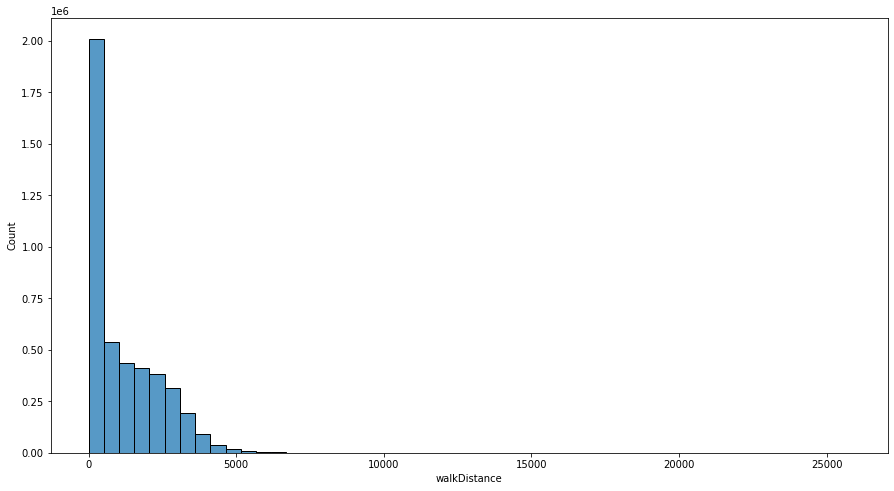

In [61]:
show_distplot('walkDistance')

In [62]:
#Travel Lust and Wandrer ---> They just play to roam around and explore places without killing anyone.
train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
23026,8a6562381dd83f,23e638cd6eaf77,b0a804a610e9b0,0,1,0.000000,0,0,0,44,...,9.882000,0,0,13530.0,7,0,0.8163,13540.302734,0.0,False
497965,3304d0c68e27f5,503757159d22dd,ce88f9c8c35bdf,0,0,0.000000,0,0,0,46,...,381.899994,0,0,25780.0,0,0,0.9894,26161.908203,0.0,False
1072113,692e7657b6e340,10baa5ce3cdffe,ad7403ad4d20a9,0,1,0.000000,0,0,5,50,...,15.270000,1,0,13040.0,4,0,0.6786,13055.289062,0.0,False
1137979,3c23cf6c61171f,90b6aaaa2a16b7,a52c5ac7c18311,0,2,0.000000,0,0,27,41,...,80.339996,0,0,13160.0,3,0,0.9643,13240.394531,0.0,False
1188935,2dd8f83eb3bd7f,d1e7809ff69bb4,c8585bc8a88aa6,0,0,0.000000,0,0,0,44,...,180.699997,0,0,13360.0,4,0,0.9643,14798.700195,0.0,False
1797162,7b9a750b17e9c6,2d00192e4029c5,6fe77402ddb0e1,0,0,0.000000,0,0,0,55,...,129.399994,0,0,16250.0,3,0,0.6000,16379.440430,0.0,False
2078996,1284474083cc33,fa7e10443cc7df,c62835e88e61a6,0,2,0.000000,0,0,3,48,...,256.899994,0,0,14250.0,8,0,0.8000,15354.600586,0.0,False
2238900,861d1e5a63f3e6,1da6a90addf96d,16f2c51578f323,0,1,0.000000,0,0,5,46,...,389.500000,0,0,15370.0,7,0,0.8125,15759.510742,0.0,False
2990339,fc3fdd39dcd266,f901321bc27871,c0ebfb404aaa47,0,4,75.349998,0,0,0,40,...,42.189999,0,0,13070.0,4,0,0.9286,14902.190430,0.0,False
3318429,25a548c95fa48f,978df298b094ba,99407bcde7569c,0,0,0.000000,0,0,2,39,...,38.439999,0,0,13660.0,1,0,0.8913,13698.454102,0.0,False


In [63]:
# Drop walking anomalies
train.drop(train[(train['walkDistance'] >= 13000) & (train['kills'] == 0)].index, inplace=True)

### **Finding Anomalies in Riding**

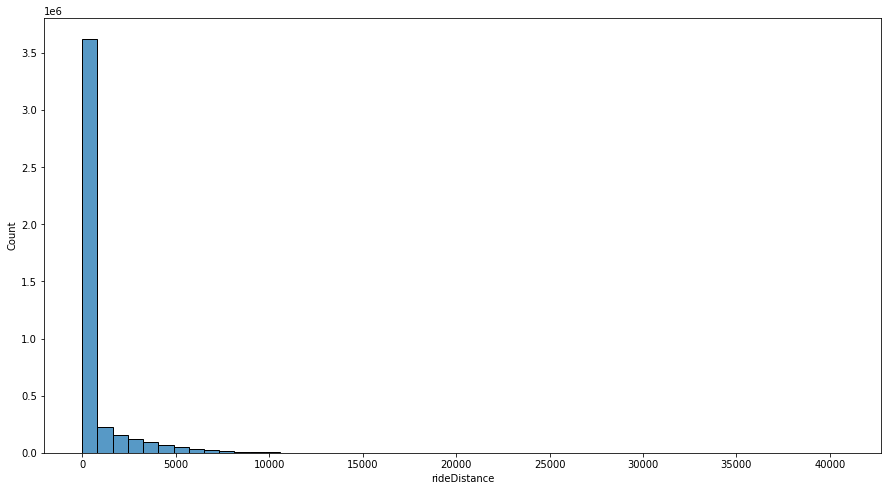

In [64]:
show_distplot('rideDistance')

In [65]:
#Travel Lust and Wandrer ---> They just play to roam around and explore places without killing anyone
train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
426708,149e224a2330ae,6d8cb80b3de8ff,f8b8e2643f60ee,0,2,0.000,0,0,2,43,...,0.0,0,0,402.100006,3,1449,0.8171,32362.099609,0.0,False
605623,8dee54600c67ca,e77f3e175b5959,26bc606cdae6bf,0,0,11.210,0,0,0,27,...,0.0,0,0,1641.000000,0,1498,0.6800,35611.000000,0.0,False
1232362,4bf27787223351,b0140dd17f3238,5ed9c405f7e71d,0,1,0.000,0,0,10,47,...,0.0,1,0,1473.000000,3,0,0.7979,32483.000000,0.0,False
1725337,9f14f77b6dd9b6,8a2a8ae2506323,904b5fa7f59bc5,0,2,2.389,0,0,5,19,...,0.0,0,0,542.099976,2,1565,0.6944,38212.101562,0.0,False
2137063,73b793b4e7523f,f4444641af7e5c,6385f7641268c3,0,0,0.000,0,0,0,52,...,0.0,0,0,28.760000,0,0,0.7204,31398.759766,0.0,False


In [66]:
# How is it even possible that a player is able to ride and kill without walking even a single meter ?
train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
219621,49e86bcbb74918,5bf4ac7f5f89a0,05a97d10e3cf81,0,0,100.000000,1,0,0,38,...,0.0,0,0,0.0,0,0,0.0000,673.099976,0.0,False
1051447,c43116d1c3d4e5,bd09c97b67800a,aad60eee7eeb79,0,0,102.199997,0,0,0,34,...,0.0,0,0,0.0,0,1532,0.1250,1757.000000,0.0,False
1053213,4a8011f19b0e0e,037c89b0cef255,238171821a1d0e,1,0,100.000000,1,0,0,38,...,0.0,0,0,0.0,0,1747,0.0638,36.240002,0.0,False
1166930,553f199b5538c5,560c2ba9dcbbd0,afb05e37d884fc,2,0,168.500000,1,0,0,45,...,0.0,0,0,0.0,0,1499,0.0667,391.799988,0.0,False
1479750,bcdf0f6c5d08bf,ea2ed2cc5955dd,2b59ed013eaf15,0,0,100.000000,1,0,0,46,...,0.0,0,0,0.0,0,0,0.0612,468.299988,0.0,False
2221273,a280df87d394fc,61042f8c96538c,a0e8fe0599288c,0,0,100.000000,1,0,0,37,...,0.0,0,0,0.0,0,0,0.1522,534.500000,0.0,False
2382410,adbda59d2f11cd,343d453ffb18c8,cbb5f864c6f532,0,0,100.000000,1,0,0,43,...,0.0,0,0,0.0,0,0,0.0000,262.700012,0.0,False
2471705,b968373063f5a8,536e9c19659ce8,61c90034dc8174,0,0,93.470001,1,0,0,38,...,0.0,0,0,0.0,0,0,0.1429,1360.000000,0.0,False
2907639,2bf1d34142358b,71c15011651348,08dfa30b9390f7,4,0,578.000000,0,0,6,30,...,0.0,0,0,0.0,29,0,0.4000,1277.000000,0.0,False
3778837,ca3ca72549b07f,68a0c84f3b09aa,f72f06cafb3349,0,0,144.300003,2,0,0,20,...,0.0,0,0,0.0,0,1496,0.0000,415.399994,0.0,False


In [67]:
# When total distance travelled by him/her is 0.
train[(train['_totalDistance'] == 0)].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
29,ac5b57ff39979c,857cc55b2b6001,e019e04dee4f19,0,0,0.0,0,0,0,87,...,0.0,0,0,0.0,0,0,0.0000,0.0,0.0,False
116,6adb021f5165ff,58e5500bd40898,de5c692fe25a73,0,0,0.0,0,0,0,68,...,0.0,0,0,0.0,0,847,0.0000,0.0,0.0,False
151,a2bbe20aa8789d,926e8a09bab249,e36e4203ed4831,0,0,0.0,0,0,0,92,...,0.0,0,0,0.0,0,765,0.0000,0.0,0.0,False
237,baaa694658e085,d034728f22cff7,fa71620624d3e7,0,0,0.0,0,0,0,94,...,0.0,0,0,0.0,0,1510,0.0000,0.0,0.0,False
283,3ab8128e6bcbe6,bb52a209f2e938,aabd2650b129e2,0,0,0.0,0,0,0,84,...,0.0,0,0,0.0,0,0,0.1277,0.0,0.0,False


In [68]:
# Drop riding anomalies
train.drop(train[(train['rideDistance'] >= 30000) & (train['kills'] == 0)].index, inplace = True)
train.drop(train[(train['walkDistance'] == 0) & (train['rideDistance'] > 0) & (train['kills'] > 0)].index, inplace = True)
train.drop(train[(train['_totalDistance'] == 0)].index, inplace=True)

### **Swim Distance**

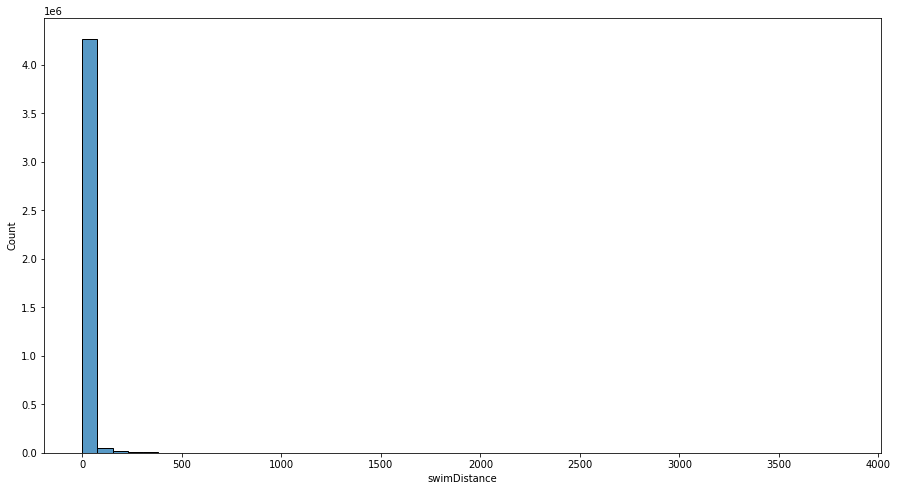

In [69]:
show_distplot('swimDistance') 

In [70]:
# How can you swim for more than 2 km without breathing?
train[train['swimDistance'] >= 2000].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
177973,c2e9e5631f4e54,23213058f83abe,f01eb1073ef377,0,5,78.120003,1,0,1,47,...,2295.0,0,0,1002.000000,4,1466,0.9592,3297.000000,0.0,False
274258,ba5e3dfb5a0fa0,383db055216ec2,d6e13468e28ab4,0,4,53.320000,0,0,16,39,...,2148.0,0,0,2276.000000,5,0,0.9600,10113.000000,0.0,False
1005337,d50c9d0e65fe2a,4996575c11abcb,668402592429f8,0,1,503.000000,4,3,1,6,...,2718.0,0,0,4691.000000,5,1516,1.0000,10740.000000,1.0,False
1195818,f811de9de80b70,d08ddf7beb6252,8a48703ab52ec8,0,7,352.299988,3,1,6,4,...,2668.0,0,0,415.100006,10,1499,1.0000,3083.100098,0.2,False
1227362,a33e917875c80e,5b72674b42712b,5fb0d8b1fc16cf,0,1,589.200012,3,1,1,46,...,3823.0,0,0,995.299988,9,0,1.0000,4818.299805,0.5,False


In [71]:
# Remove outliers
train.drop(train[train['swimDistance'] >= 2000].index, inplace=True)

### **Anomalies detection in Supplies (WeaponAcquired)**

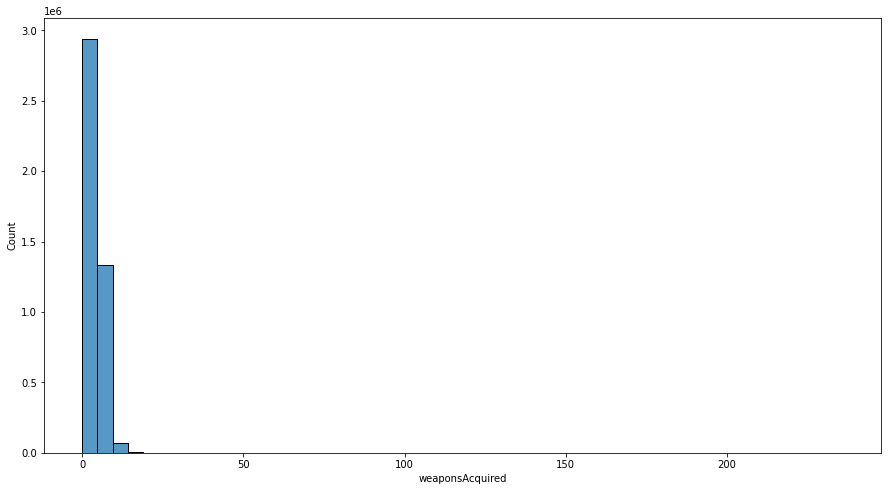

In [72]:
show_distplot('weaponsAcquired')

In [73]:
display(train[train['weaponsAcquired'] >= 80].shape)
train[train['weaponsAcquired'] >= 80].head()

(21, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.110001,0,0,0,44,...,0.000000,0,0,1307.000000,128,1577,0.7111,3187.000000,0.000000,False
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.300003,1,0,2,48,...,0.000000,0,0,1687.000000,80,0,0.7500,1687.000000,0.000000,False
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.000000,0,0,0,24,...,47.209999,0,0,2400.000000,102,0,0.8929,5299.209961,0.000000,False
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.000000,0,0,0,54,...,0.000000,0,0,653.099976,95,0,0.5600,653.099976,0.000000,False
1462706,be4ff9afaa5bb1,abb73dd57619fa,f900de1ec39fa5,22,0,5377.000000,0,8,4,3,...,0.000000,0,0,1128.000000,83,0,0.8000,2082.399902,0.150943,False


In [74]:
# Remove outliers
train.drop(train[train['weaponsAcquired'] >= 80].index, inplace=True)

### **Anomalies in Heals**

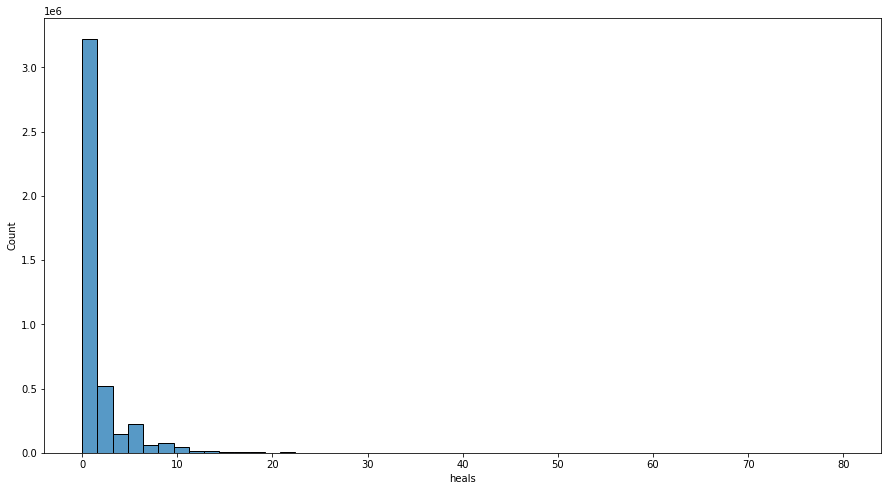

In [75]:
show_distplot('heals')

In [76]:
# 40 or more healing items used
display(train[train['heals'] >= 40].shape)
train[train['heals'] >= 40].head(5)

(135, 32)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
18405,63ab976895d860,927eeba5614c4f,69473402649f11,0,2,0.0,0,0,47,43,...,0.000000,0,0,1387.0,6,0,0.9368,6854.000000,0.0,False
54463,069ddee7c9d26a,58ab5a1ce8e06f,942416b6caf21e,1,4,182.0,0,1,43,21,...,292.399994,0,0,2791.0,7,0,0.9615,3083.399902,1.0,False
126439,c45bd6917146e2,81ab9f863957cb,4335664c6716fa,0,2,0.0,0,0,52,49,...,3.443000,0,0,1340.0,3,1543,0.8333,1343.442993,0.0,False
259351,86910c38335c2f,2738398928d28c,7d2911e944bfaa,0,10,0.0,0,0,42,45,...,0.000000,0,0,1510.0,6,0,0.8646,7444.000000,0.0,False
268747,a007734fbc6ebf,5bf702dfa1e5d4,ad6b5669d33a2c,0,5,0.0,0,0,48,43,...,0.000000,0,0,1968.0,9,0,0.8370,5816.000000,0.0,False


In [77]:
# Remove outliers
train.drop(train[train['heals'] >= 40].index, inplace=True)

## **Cleaned data**

In [78]:
train.shape

(4349359, 32)

In [79]:
train.to_csv('pubg-finish-placement-prediction/cleaned_data.csv', index = False)

In [80]:
cleaned_data = pd.read_csv('pubg-finish-placement-prediction/cleaned_data.csv')
reduce_memory(cleaned_data)

Memory usage of dataframe is 1032.82 MB --> 377.46 MB (Decreased by 63.5%)


## **Feature Engineering**

### **Experiment: Adding/Removing some new Features and finding thier correlation with the winPlacePer**

In [81]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,_totalDistance,_headshot_rate,_killsWithoutMoving
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0.00,0,0,244.800003,1,1466,0.4444,244.800003,0.0,0.0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,11.04,0,0,1434.000000,5,0,0.6400,1445.044556,0.0,0.0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0.00,0,0,161.800003,2,0,0.7755,161.800003,0.0,0.0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,0.00,0,0,202.699997,3,0,0.1667,202.699997,0.0,0.0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0.00,0,0,49.750000,2,0,0.1875,49.750000,0.0,0.0


In [82]:
cleaned_data.shape

(4349359, 32)

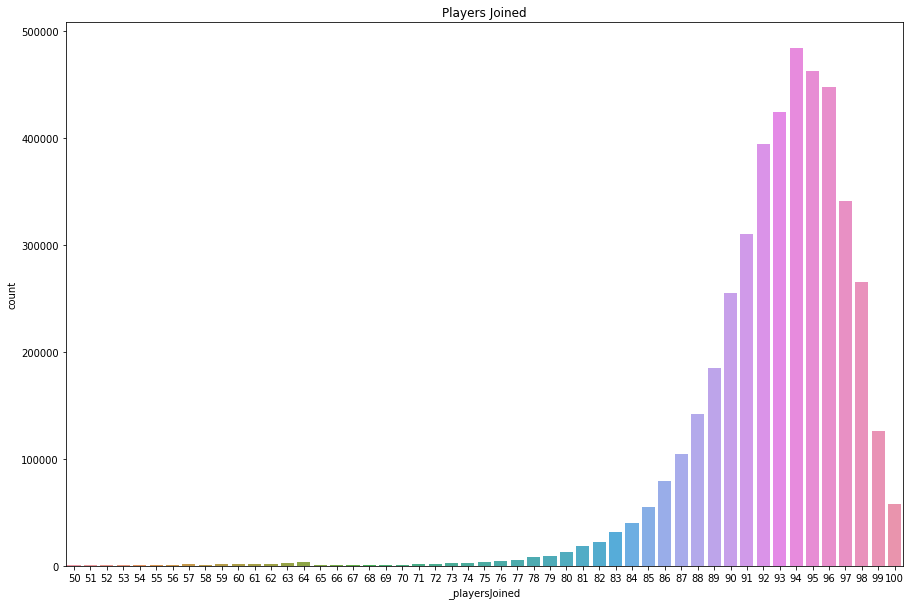

In [83]:
cleaned_data['_playersJoined'] = cleaned_data.groupby('matchId')['matchId'].transform('count')
data = cleaned_data.copy()
data = data[data['_playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(x = data['_playersJoined'])
plt.title("Players Joined")
plt.show()

### **Normalizing the features**

#### **Now that we have a feature '_playersJoined' we can normalize other features based on the amount of players. Features that can be valuable to normalize are:**

- **kills**
- **damageDealt**
- **maxPlace**
- **matchDuration**

In [84]:
# Create normalized features
cleaned_data['_killsNorm'] = cleaned_data['kills']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_damageDealtNorm'] = cleaned_data['damageDealt']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_maxPlaceNorm'] = cleaned_data['maxPlace']*((100-cleaned_data['_playersJoined'])/100 + 1)
cleaned_data['_matchDurationNorm'] = cleaned_data['matchDuration']*((100-cleaned_data['_playersJoined'])/100 + 1)
# Compare standard features and normalized features
to_show = ['Id', 'kills','_killsNorm','damageDealt', '_damageDealtNorm', 'maxPlace', '_maxPlaceNorm', 'matchDuration', '_matchDurationNorm']
cleaned_data[to_show][0:11]


,Id,kills,_killsNorm,damageDealt,_damageDealtNorm,maxPlace,_maxPlaceNorm,matchDuration,_matchDurationNorm
0,7f96b2f878858a,0,0.00,0.000000,0.000000,28,29.68,1306,1384.36
1,eef90569b9d03c,0,0.00,91.470001,100.617001,26,28.60,1777,1954.70
2,1eaf90ac73de72,0,0.00,68.000000,72.760000,50,53.50,1318,1410.26
3,4616d365dd2853,0,0.00,32.900002,35.861002,31,33.79,1436,1565.24
4,315c96c26c9aac,1,1.06,100.000000,106.000000,97,102.82,1424,1509.44
5,ff79c12f326506,1,1.09,100.000000,109.000000,28,30.52,1395,1520.55
6,95959be0e21ca3,0,0.00,0.000000,0.000000,28,28.84,1316,1355.48
7,311b84c6ff4390,0,0.00,8.538000,9.221040,96,103.68,1967,2124.36
8,1a68204ccf9891,0,0.00,51.599998,54.179998,28,29.40,1375,1443.75
9,e5bb5a43587253,0,0.00,37.270000,40.251600,29,31.32,1930,2084.40


In [85]:
match = cleaned_data.groupby('matchId')
cleaned_data['_killsPerc'] = match['kills'].rank(pct=True).values
cleaned_data['_killPlacePerc'] = match['killPlace'].rank(pct=True).values
cleaned_data['_walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
cleaned_data['_damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
cleaned_data['_walkPerc_killsPerc'] = cleaned_data['_walkDistancePerc'] / cleaned_data['_killsPerc']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,_playersJoined,_killsNorm,_damageDealtNorm,_maxPlaceNorm,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,94,0.00,0.000000,29.68,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,90,0.00,100.617001,28.60,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,93,0.00,72.760000,53.50,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,91,0.00,35.861002,33.79,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,94,1.06,106.000000,102.82,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194


In [86]:
corr = cleaned_data[['_killsPerc', '_killPlacePerc','_walkDistancePerc','_damageDealtPerc', '_walkPerc_killsPerc','winPlacePerc']].corr()

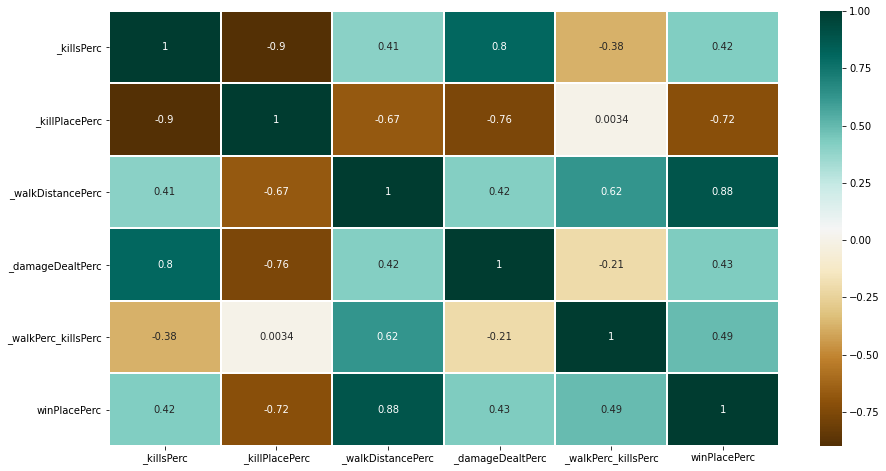

In [87]:
plt.figure(figsize=(15,8))
sns.heatmap(corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    annot=True,
    cmap="BrBG"
)
plt.show()

In [88]:
agg = cleaned_data.groupby(['groupId']).size().to_frame('players_in_team')
cleaned_data = cleaned_data.merge(agg, how='left', on=['groupId'])
cleaned_data['_healthItems'] = cleaned_data['heals'] + cleaned_data['boosts']
cleaned_data['_headshotKillRate'] = cleaned_data['headshotKills'] / cleaned_data['kills']
cleaned_data['_killPlaceOverMaxPlace'] = cleaned_data['killPlace'] / cleaned_data['maxPlace']
cleaned_data['_killsOverWalkDistance'] = cleaned_data['kills'] / cleaned_data['walkDistance']
cleaned_data['_killsOverDistance'] = cleaned_data['kills'] / cleaned_data['_totalDistance']
cleaned_data['_walkDistancePerSec'] = cleaned_data['walkDistance'] / cleaned_data['matchDuration']
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_headshotKillRate,_killPlaceOverMaxPlace,_killsOverWalkDistance,_killsOverDistance,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,0.468085,0.148936,1.571429,4,0,NaN,2.142857,0.000000,0.000000,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,0.555556,0.433333,2.222222,4,0,NaN,2.192308,0.000000,0.000000,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,0.344086,0.419355,1.230769,2,0,NaN,0.940000,0.000000,0.000000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,0.230769,0.296703,0.840000,1,0,NaN,2.419355,0.000000,0.000000,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,0.180851,0.563830,0.274194,1,0,0.0,0.463918,0.020101,0.020101,0.034937


In [89]:
agg

,players_in_team
groupId,
00000c08b5be36,3
00000d1cbbc340,1
000025a09dd1d7,1
000038ec4dff53,3
00003a54230763,2
...,...
ffffedb6ecff6a,2
fffff305a0133d,2
fffff32bc7eab9,1


In [90]:
corr = cleaned_data[['killPlace', 'walkDistance','players_in_team','_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance', '_killsOverDistance','_walkDistancePerSec','winPlacePerc']].corr()

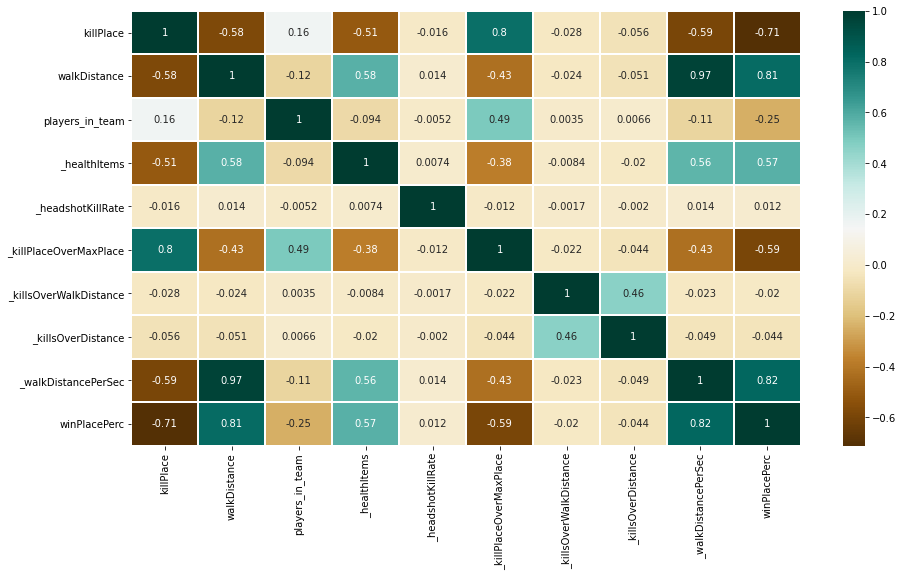

In [91]:
plt.figure(figsize=(15,8))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    linecolor='white',
    linewidths=0.1,
    cmap="BrBG"
)
plt.show()

In [92]:
cleaned_data.shape

(4349359, 49)

In [93]:
cleaned_data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', '_totalDistance',
       '_headshot_rate', '_killsWithoutMoving', '_playersJoined', '_killsNorm',
       '_damageDealtNorm', '_maxPlaceNorm', '_matchDurationNorm', '_killsPerc',
       '_killPlacePerc', '_walkDistancePerc', '_damageDealtPerc',
       '_walkPerc_killsPerc', 'players_in_team', '_healthItems',
       '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance',
       '_killsOverDistance', '_walkDistancePerSec'],
      dtype='object')

In [94]:
cleaned_data.drop(['_headshotKillRate','_killsOverDistance', '_killsOverWalkDistance', ], axis=1, inplace=True)

In [95]:
cleaned_data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,_matchDurationNorm,_killsPerc,_killPlacePerc,_walkDistancePerc,_damageDealtPerc,_walkPerc_killsPerc,players_in_team,_healthItems,_killPlaceOverMaxPlace,_walkDistancePerSec
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000000,0,0,0,60,...,1384.36,0.297872,0.638298,0.468085,0.148936,1.571429,4,0,2.142857,0.187443
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470001,0,0,0,57,...,1954.70,0.250000,0.633333,0.555556,0.433333,2.222222,4,0,2.192308,0.806978
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000000,0,0,0,47,...,1410.26,0.279570,0.505376,0.344086,0.419355,1.230769,2,0,0.940000,0.122762
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900002,0,0,0,75,...,1565.24,0.274725,0.824176,0.230769,0.296703,0.840000,1,0,2.419355,0.141156
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000000,0,0,0,45,...,1509.44,0.659574,0.478723,0.180851,0.563830,0.274194,1,0,0.463918,0.034937


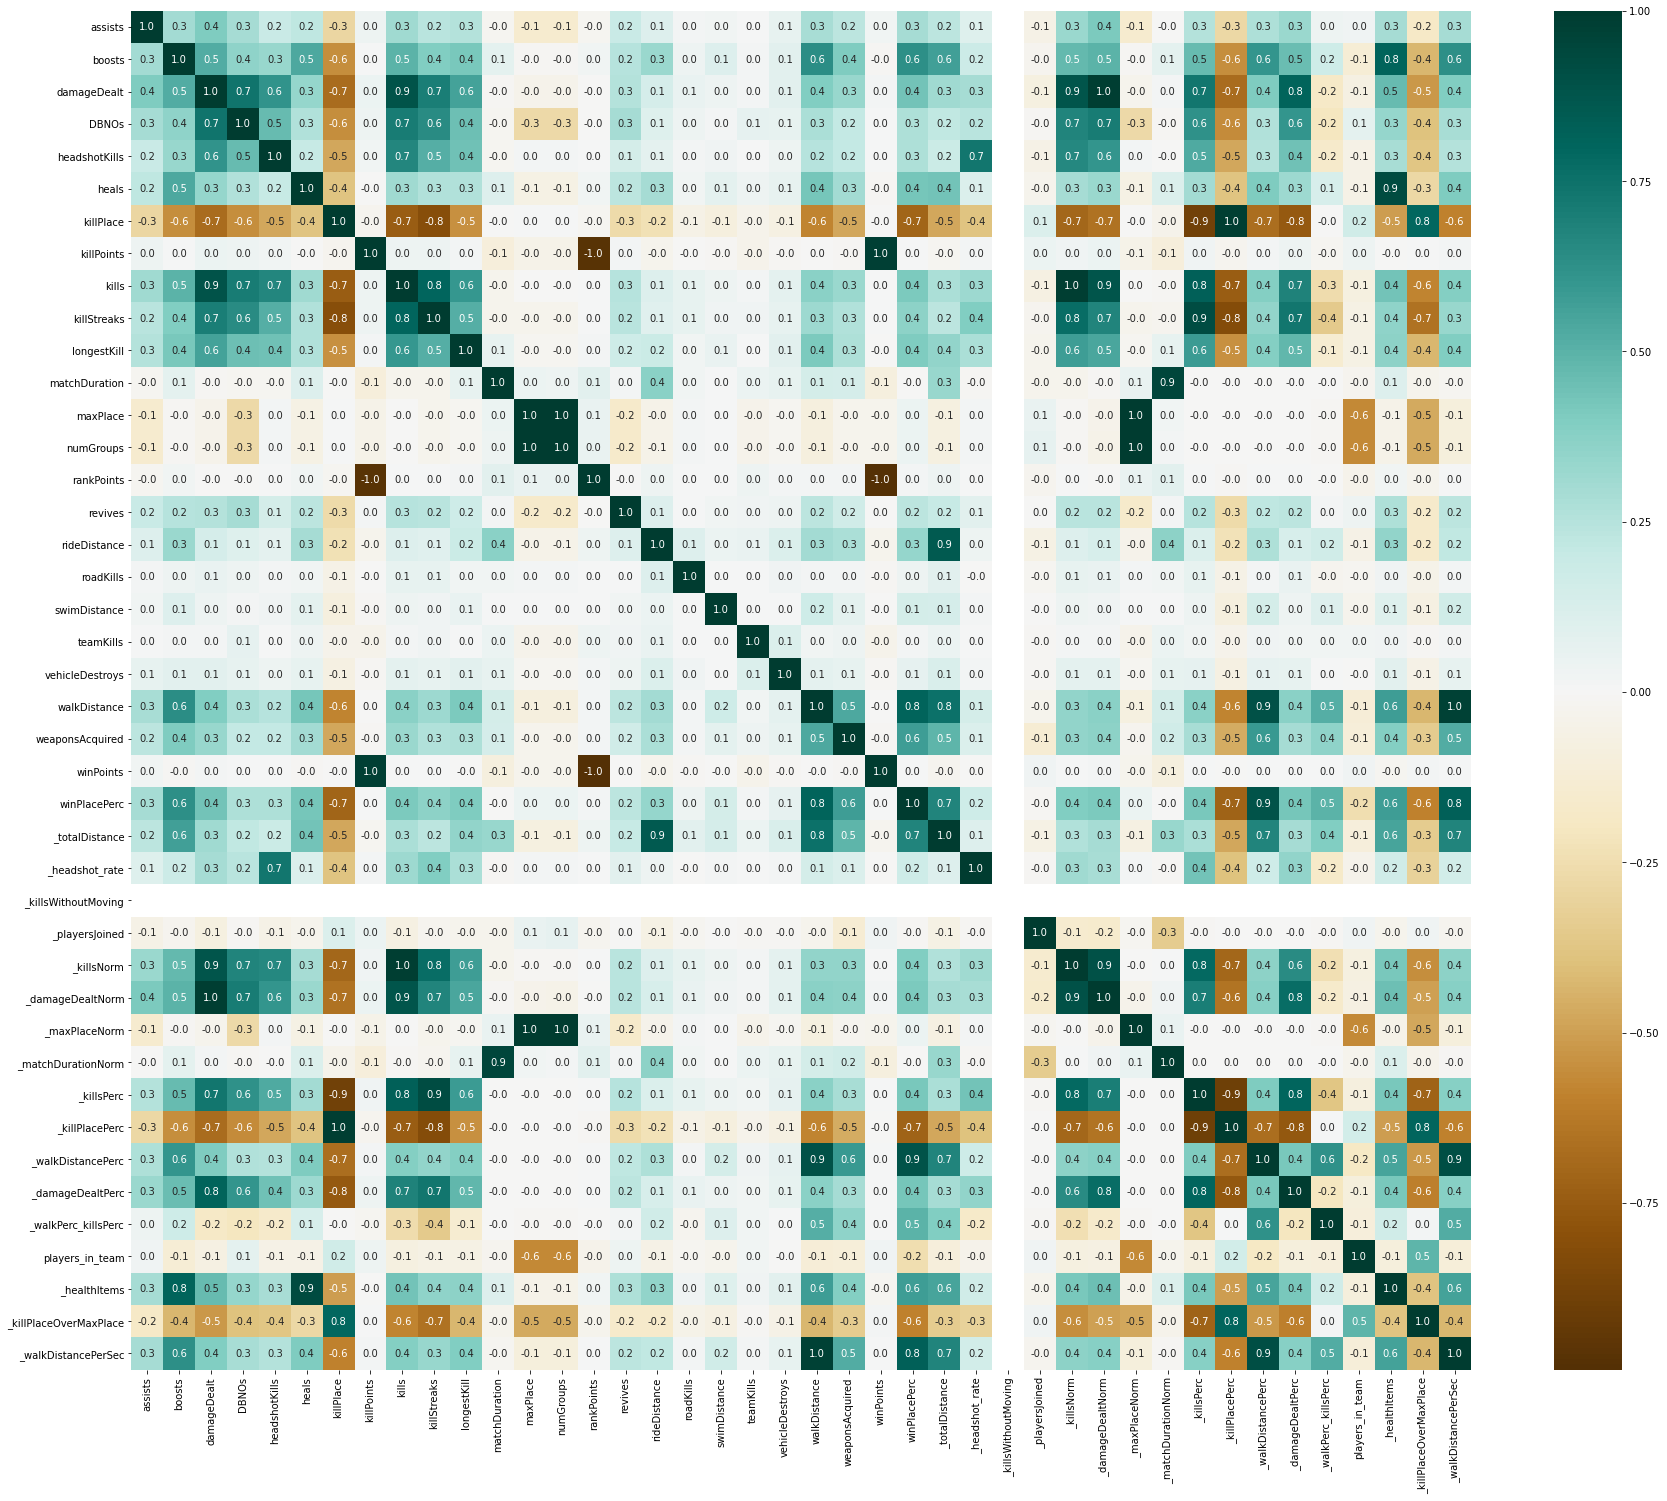

In [96]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 25))
sns.heatmap(cleaned_data[cols_to_fit].corr(), annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

### **Removing features having 0 correlation with winPlacePerc**

In [97]:
cleaned_data.drop(['killPoints','matchDuration','maxPlace','numGroups','rankPoints','roadKills','teamKills','winPoints',
                   '_playersJoined', '_maxPlaceNorm', '_matchDurationNorm', '_killsWithoutMoving'], axis=1, inplace=True) 

In [98]:
cleaned_data.shape

(4349359, 34)

### **Removing variables with high correlation between them**

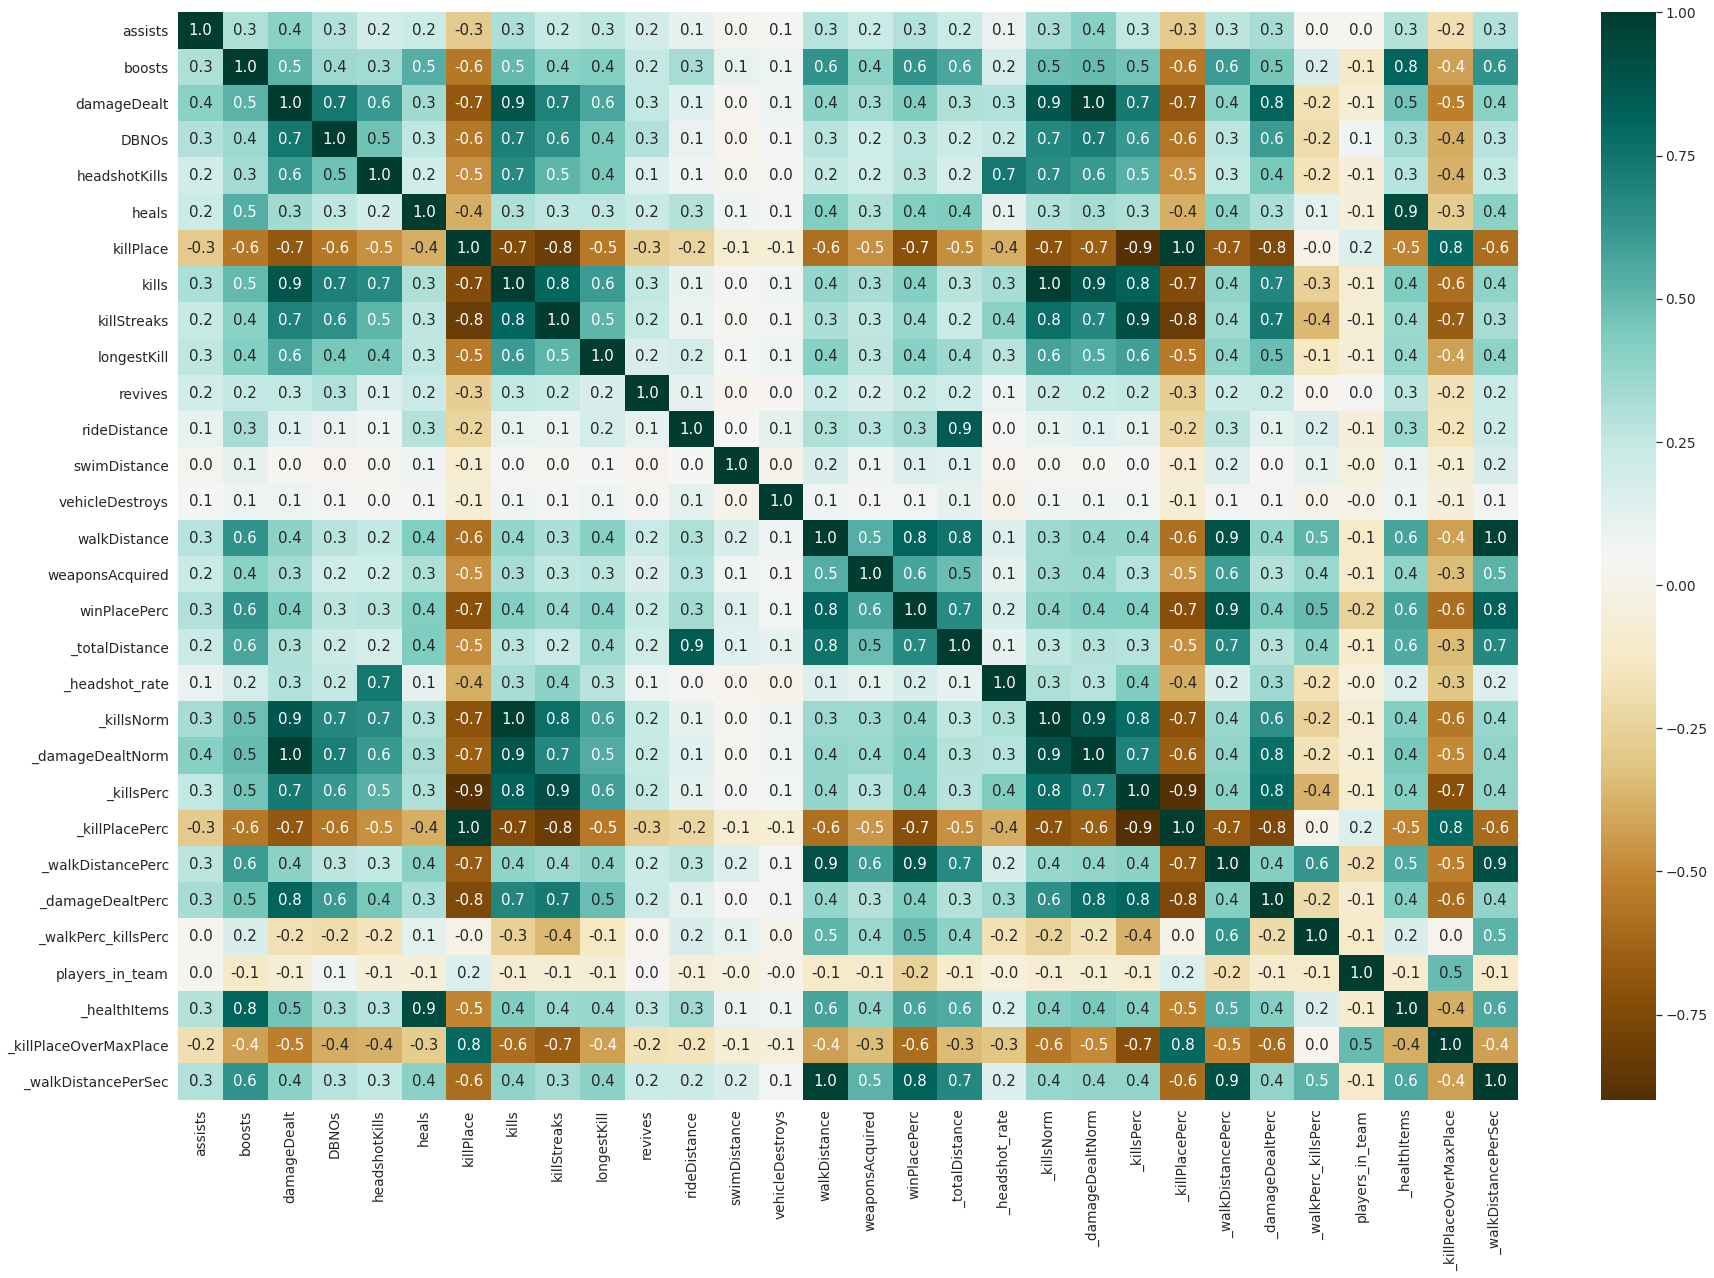

In [99]:
cols_to_fit = [col for col in cleaned_data.columns]
corr = cleaned_data[cols_to_fit].corr()
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(corr, annot=True, fmt= '.1f',ax=ax, cmap="BrBG")
sns.set(font_scale=1.25)
plt.show()

In [100]:
test.shape

(1934174, 28)

In [101]:
#saving highly correlated data
cleaned_data.to_csv('pubg-finish-placement-prediction/Highly_correlated_data.csv', index=False)

## **Final Prediction**

In [102]:
highly_corr = pd.read_csv('pubg-finish-placement-prediction/Highly_correlated_data.csv')
reduce_memory(highly_corr)

Memory usage of dataframe is 1128.22 MB --> 468.71 MB (Decreased by 58.5%)


In [103]:
highly_corr.shape

(4349359, 34)

In [104]:
X_train = highly_corr[highly_corr['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = highly_corr[highly_corr['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)


Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()
train_matchId = X_train['matchId']

# drop matchId,groupId
X_train.drop(['matchId','groupId','Id'], axis=1, inplace=True)
X_test.drop(['matchId','groupId','Id'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(4349359, 30) (0, 30)


In [105]:
highly_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4349359 entries, 0 to 4349358
Data columns (total 34 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Id                      object 
 1   groupId                 object 
 2   matchId                 object 
 3   assists                 int8   
 4   boosts                  int8   
 5   damageDealt             float32
 6   DBNOs                   int8   
 7   headshotKills           int8   
 8   heals                   int8   
 9   killPlace               int8   
 10  kills                   int8   
 11  killStreaks             int8   
 12  longestKill             float32
 13  matchType               object 
 14  revives                 int8   
 15  rideDistance            float32
 16  swimDistance            float32
 17  vehicleDestroys         int8   
 18  walkDistance            float32
 19  weaponsAcquired         int8   
 20  winPlacePerc            float32
 21  _totalDistance          float32

In [106]:
print('There are {} different matchTypes in the dataset.'.format(highly_corr['matchType'].nunique()))

There are 3 different matchTypes in the dataset.


In [107]:
# One hot encode matchType
highly_corr = pd.get_dummies(highly_corr, columns=['matchType'])

In [108]:
# Turn groupId and match Id into categorical types
highly_corr['groupId'] = highly_corr['groupId'].astype('category')
highly_corr['matchId'] = highly_corr['matchId'].astype('category')

# Get category coding for groupId and matchID
highly_corr['groupId_cat'] = highly_corr['groupId'].cat.codes
highly_corr['matchId_cat'] = highly_corr['matchId'].cat.codes

# Get rid of old columns
highly_corr.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
highly_corr[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,609242,29996
1,821700,32654
2,837266,3131
3,1330566,45133
4,1744863,20468


In [109]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
highly_corr.drop(columns = ['Id'], inplace=True)

### **Sampling**

In [110]:
# Take sample for debugging and exploration
sample = 500000
df_sample = highly_corr.sample(sample)

In [111]:
# Split sample into training data and target variable
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [112]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 34) Sample target shape:  (440000,) Sample validation shape:  (60000, 34)


In [153]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Function to print the MAE (Mean Absolute Error) score

def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    #Score of the training dataset obtained using an out-of-bag estimate.
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### **Creating a basic Random Forest Model**

In [154]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.029942309707415998, 'mae val: ', 0.05045267444364856]


- **Feature Importance using Random Forest**

In [115]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [116]:
fi = rf_feat_importance(m1, df); fi[:15]

,cols,imp
22,_walkDistancePerc,0.203533
14,walkDistance,0.135216
28,_walkDistancePerSec,0.111781
21,_killPlacePerc,0.100066
6,killPlace,0.095018
16,_totalDistance,0.058600
1,boosts,0.054214
24,_walkPerc_killsPerc,0.048399
27,_killPlaceOverMaxPlace,0.040711
26,_healthItems,0.027381


<AxesSubplot:ylabel='cols'>

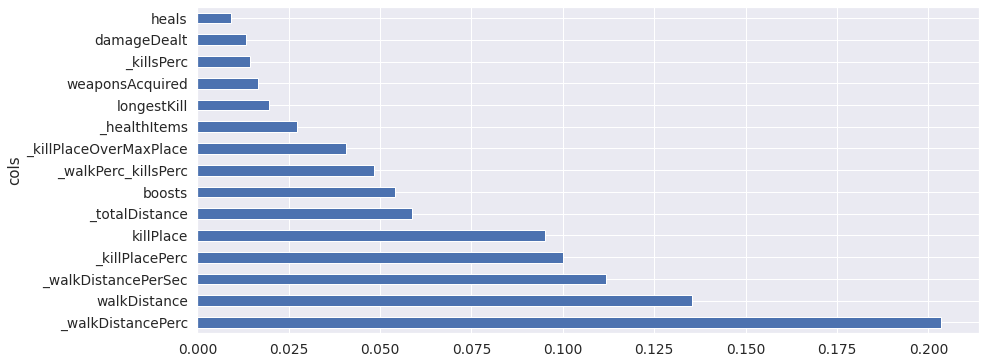

In [117]:
# Feature importance graph for the 20 most important features
plot1 = fi[:15].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [118]:
X_train.columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'kills', 'killStreaks', 'longestKill', 'revives',
       'rideDistance', 'swimDistance', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', '_totalDistance', '_headshot_rate', '_killsNorm',
       '_damageDealtNorm', '_killsPerc', '_killPlacePerc', '_walkDistancePerc',
       '_damageDealtPerc', '_walkPerc_killsPerc', 'players_in_team',
       '_healthItems', '_killPlaceOverMaxPlace', '_walkDistancePerSec',
       'matchType_duo', 'matchType_solo', 'matchType_squad', 'groupId_cat',
       'matchId_cat'],
      dtype='object')

In [119]:
print(X_train.shape, y_train.shape)

(440000, 34) (440000,)


In [120]:
# Keep only significant features
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  18


22         _walkDistancePerc
14              walkDistance
28       _walkDistancePerSec
21            _killPlacePerc
6                  killPlace
16            _totalDistance
1                     boosts
24       _walkPerc_killsPerc
27    _killPlaceOverMaxPlace
26              _healthItems
9                longestKill
15           weaponsAcquired
20                _killsPerc
2                damageDealt
5                      heals
11              rideDistance
25           players_in_team
8                killStreaks
Name: cols, dtype: object

In [121]:
# Make a DataFrame with only significant features
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

- **Building a Random Forest Model with top features**

In [122]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt', n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.029644890485345618, 'mae val: ', 0.05016639938870704]


<AxesSubplot:ylabel='cols'>

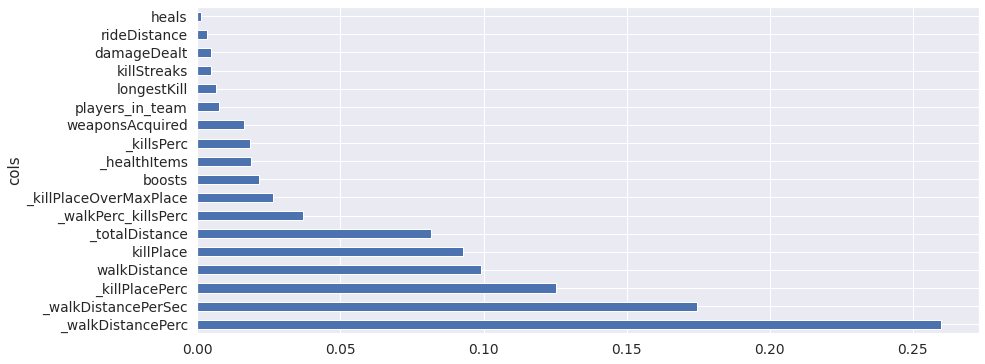

In [123]:
# Get feature importances of our top features
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

In [124]:
df_keep.head()

,_walkDistancePerc,walkDistance,_walkDistancePerSec,_killPlacePerc,killPlace,_totalDistance,boosts,_walkPerc_killsPerc,_killPlaceOverMaxPlace,_healthItems,longestKill,weaponsAcquired,_killsPerc,damageDealt,heals,rideDistance,players_in_team,killStreaks
194531,0.351648,244.600006,0.171529,0.747253,68,254.438004,0,1.333333,1.478261,0,0.000000,2,0.263736,151.000000,0,0.000000,3,0
731097,0.074468,36.860001,0.018758,0.957447,90,36.860001,0,0.237288,1.875000,0,0.000000,1,0.313830,0.000000,0,0.000000,2,0
4336037,0.500000,1488.000000,0.756482,0.191489,19,4995.000000,0,0.580247,0.678571,1,357.700012,3,0.861702,175.000000,1,3507.000000,4,1
4283127,0.602151,671.200012,0.449264,0.526882,49,671.200012,0,2.036364,0.510417,0,0.000000,5,0.295699,43.560001,0,0.000000,1,0
832094,0.965517,3107.000000,1.536597,0.310345,18,3830.100098,5,1.534247,1.200000,16,183.300003,4,0.629310,673.200012,11,723.099976,3,1


In [125]:
# Train final model
# You should get better results by increasing n_estimators
# and by playing around with the parameters
m3 = RandomForestRegressor(n_estimators=50, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)

['mae train: ', 0.02629934514463723, 'mae val: ', 0.04880366390195661]


### **Modifying test data**

In [126]:
test = pd.read_csv('pubg-finish-placement-prediction/test_V2.csv')
reduce_memory(test)

Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)


In [127]:
#Adding same features to test data
agg = test.groupby(['groupId']).size().to_frame('players_in_team')
test = test.merge(agg, how='left', on=['groupId'])
test['_headshot_rate'] = test['headshotKills'] / test['kills']
test['_headshot_rate'] = test['_headshot_rate'].fillna(0)
test['_totalDistance'] = test['rideDistance'] + test['walkDistance'] + test['swimDistance']
test['_playersJoined'] = test.groupby('matchId')['matchId'].transform('count')
test['_killsNorm'] = test['kills']*((100-test['_playersJoined'])/100 + 1)
test['_damageDealtNorm'] = test['damageDealt']*((100-test['_playersJoined'])/100 + 1)
test['_damageDealtPerc'] = test['damageDealt'].rank(pct=True).values
test['_healthItems'] = test['heals'] + test['boosts']
test['killsWithoutMoving'] = ((test['kills'] > 0) & (test['_totalDistance'] == 0))
test['_killPlacePerc'] = test['killPlace'].rank(pct=True).values
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkPerc_killsPerc'] = test['_walkDistancePerc'] / test['_killsPerc']
test['_killPlaceOverMaxPlace'] = test['killPlace'] / test['maxPlace']
test['_killsPerc'] = test['kills'].rank(pct=True).values
test['_walkDistancePerc'] = test['walkDistance'].rank(pct=True).values
test['_walkDistancePerSec'] = test['walkDistance'] / test['matchDuration']


In [128]:

# Turn groupId and match Id into categorical types
test['groupId'] = test['groupId'].astype('category')
test['matchId'] = test['matchId'].astype('category')

# Get category coding for groupId and matchID
test['groupId_cat'] = test['groupId'].cat.codes
test['matchId_cat'] = test['matchId'].cat.codes

In [129]:
# # Remove irrelevant features from the test set
test_pred = test[to_keep].copy()

# Fill NaN with 0 (temporary)
test_pred.fillna(0, inplace=True)
test_pred.head()

,_walkDistancePerc,walkDistance,_walkDistancePerSec,_killPlacePerc,killPlace,_totalDistance,boosts,_walkPerc_killsPerc,_killPlaceOverMaxPlace,_healthItems,longestKill,weaponsAcquired,_killsPerc,damageDealt,heals,rideDistance,players_in_team,killStreaks
0,0.475680,588.000000,0.312102,0.766654,73,588.000000,0,1.673695,2.607143,0,0.000000,1,0.284210,51.459999,0,0.0,4,0
1,0.758297,2017.000000,1.113749,0.111587,11,6686.000000,4,0.912373,0.229167,6,361.899994,6,0.831127,179.100006,2,4669.0,2,1
2,0.525046,787.799988,0.439375,0.513972,49,787.799988,0,1.847389,1.750000,4,0.000000,4,0.284210,23.400000,4,0.0,4,0
3,0.722077,1812.000000,0.988004,0.566769,54,1812.000000,0,2.540649,1.200000,0,0.000000,3,0.284210,65.519997,0,0.0,2,0
4,0.906597,2963.000000,2.234540,0.069081,7,2963.000000,4,0.995576,0.250000,5,60.060001,4,0.910626,330.200012,1,0.0,3,1


In [133]:
predictions = np.clip(a = m3.predict(test_pred), a_min = 0.0, a_max = 1.0)
pred_df = pd.DataFrame({'Id' : test['Id'], 'winPlacePerc' : predictions})
pred_df
# Create submission file
pred_df.to_csv("submission.csv", index=False)

In [144]:
m3.predict(test_pred.head(1))

array([0.25039438])

In [134]:
predictions

array([0.25039438, 0.92426874, 0.73928499, ..., 0.90836212, 0.81961476,
       0.08442259])

In [135]:
submission = pd.read_csv('submission.csv')

In [141]:
submission.head(10)

,Id,winPlacePerc
0,9329eb41e215eb,0.250394
1,639bd0dcd7bda8,0.924269
2,63d5c8ef8dfe91,0.739285
3,cf5b81422591d1,0.643563
4,ee6a295187ba21,0.947961
5,3e2539b5d78183,0.068963
6,d812d2f1d88a02,0.701154
7,a8a377e4d43bf8,0.296936
8,f18301e30d47d3,0.591256
9,ec7b965ef978b3,0.606199
